<center><img src='https://netacad.centralesupelec.fr/img/cs.jpg' width=200></center>
<center><img src='https://upload.wikimedia.org/wikipedia/commons/5/59/Logo_Universit%C3%A9_Paris-Saclay_%28externe%29.svg' width=200></center>
<h1><center>Prédiction de qualité de soudure</center></h1>
<h2><center>- Apprentissage Automatique -</center></h2>
<h4><center>Résumé du projet</center></h6>
<h6>Dans le contexte industriel actuel, la qualité des soudures joue un rôle fondamental pour la tenue des structures. C’est le cas dans des secteurs critiques comme l’aérospatiale, la construction navale ou l’énergie nucléaire. Ces industries sont fortement dépendantes de l'expertise des soudeurs et à la vérification de la qualité des soudures, principalement basée sur l'expérience. Or, avec le développement des techniques d'intelligence artificielle et de l'accès croissant aux données, une opportunité se présente pour capturer, standardiser et enrichir ce contrôle qualité.
</h5>

<h6>Ce notebook contient la totalité du travail qui a été réalisé. Il peut être lu linéairement
</h6>
<h1>
<hr style=" border:none; height:3px;">

<hr style=" border:none; height:3px;">
</h1>


# Import des librairies

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)
import os
# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"
# Numpy arrays are used to store training and test data.
import numpy as np
# Pandas is used to manipulate tabular data.
import pandas as pd
# Matplotlib is used to plot graphs.
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt


# Style options for plots.
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Ignore useless warnings (see SciPy issue #5998).
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

# Convenience function to create display a progress bar.
# Source : https://stackoverflow.com/questions/3173320/text-progress-bar-in-the-console
def print_progress_bar (iteration, total, prefix = '', suffix = '', decimals = 1, length = 100, fill = '█', printEnd = "\r"):
    """
    Call in a loop to create terminal progress bar
    @params:
        iteration   - Required  : current iteration (Int)
        total       - Required  : total iterations (Int)
        prefix      - Optional  : prefix string (Str)
        suffix      - Optional  : suffix string (Str)
        decimals    - Optional  : positive number of decimals in percent complete (Int)
        length      - Optional  : character length of bar (Int)
        fill        - Optional  : bar fill character (Str)
        printEnd    - Optional  : end character (e.g. "\r", "\r\n") (Str)
    """
    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filledLength = int(length * iteration // total)
    bar = fill * filledLength + '-' * (length - filledLength)
    print(f'\r{prefix} |{bar}| {percent}% {suffix}', end = printEnd)
    # Print New Line on Complete
    if iteration == total:
        print()

# Saves a figure to a file
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join("./figs", fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Chargement des données

In [2]:
# Charger les données
df = pd.read_csv('welddb.csv', sep=';')

# Remplacer les valeurs 'N' et 'None' par NaN pour faciliter le traitement des valeurs manquantes
df.replace(['N', 'None'], np.nan, inplace=True)

# Etats des lieux de la qualité du dataset 

Affichage ci-dessous de quelques informations sur le dataset pour évaluer son contenu

In [3]:
#Afficher les statistiques descriptives
df.describe()

Carbon concentration / (weight%)  Silicon concentration / (weight%)  \
count                       1652.000000                        1652.000000   
mean                           0.075521                           0.328577   
std                            0.023898                           0.112455   
min                            0.029000                           0.040000   
25%                            0.061750                           0.270000   
50%                            0.074000                           0.320000   
75%                            0.086000                           0.360000   
max                            0.180000                           1.140000   

       Manganese concentration / (weight%)  Sulphur concentration / (weight%)  \
count                          1652.000000                        1648.000000   
mean                              1.202821                           0.009529   
std                               0.382137                           0.011226   
min                               0.270000                           0.001000   
25%                               0.940000                           0.006000   
50%                               1.270000                           0.007000   
75%                               1.440000                           0.010000   
max                               2.250000                           0.140000   

       Phosphorus concentration / (weight%)  Nickel concentration / (weight%)  \
count                           1642.000000                        697.000000   
mean                               0.012952                          0.415034   
std                                0.019627                          0.786951   
min                                0.002000                          0.000000   
25%                                0.007000                          0.000000   
50%                                0.010000                          0.067000   
75%                                0.014000                          0.260000   
max                                0.250000                          3.500000   

       Chromium concentration / (weight%)  \
count                          784.000000   
mean                             2.101273   
std                              3.026548   
min                              0.000000   
25%                              0.000000   
50%                              0.530000   
75%                              2.300000   
max                             10.200000   

       Molybdenum concentration / (weight%)  \
count                            793.000000   
mean                               0.479172   
std                                0.477404   
min                                0.000000   
25%                                0.000000   
50%                                0.340000   
75%                                1.010000   
max                                1.500000   

       Vanadium concentration / (weight%)  Copper concentration / (weight%)  \
count                          928.000000                        578.000000   
mean                             0.097379                          0.172163   
std                              0.492889                          0.322933   
min                              0.000000                          0.000000   
25%                              0.000500                          0.000000   
50%                              0.009500                          0.030000   
75%                              0.044000                          0.180000   
max                              5.000000                          1.630000   

       ...  Ultimate tensile strength / MPa  Elongation / %  \
count  ...                       738.000000      700.000000   
mean   ...                       594.386314       26.275714   
std    ...                        88.636238        4.895986   
min    ...                       447.000000       

In [4]:
df.head()

Carbon concentration / (weight%)  Silicon concentration / (weight%)  \
0                             0.037                               0.30   
1                             0.037                               0.30   
2                             0.037                               0.30   
3                             0.037                               0.31   
4                             0.037                               0.31   

   Manganese concentration / (weight%)  Sulphur concentration / (weight%)  \
0                                 0.65                              0.008   
1                                 0.65                              0.008   
2                                 0.65                              0.008   
3                                 1.03                              0.007   
4                                 1.03                              0.007   

   Phosphorus concentration / (weight%)  Nickel concentration / (weight%)  \
0                                 0.012                               0.0   
1                                 0.012                               0.0   
2                                 0.012                               0.0   
3                                 0.014                               0.0   
4                                 0.014                               0.0   

   Chromium concentration / (weight%)  Molybdenum concentration / (weight%)  \
0                                 NaN                                   NaN   
1                                 NaN                                   NaN   
2                                 NaN                                   NaN   
3                                 NaN                                   NaN   
4                                 NaN                                   NaN   

   Vanadium concentration / (weight%)  Copper concentration / (weight%)  ...  \
0                                 NaN                               NaN  ...   
1                                 NaN                               NaN  ...   
2                                 NaN                               NaN  ...   
3                                 NaN                               NaN  ...   
4                                 NaN                               NaN  ...   

   Charpy temperature / deg C  Charpy impact toughness / J  Hardness / kg/mm2  \
0                         NaN                          NaN                NaN   
1                       -28.0                        100.0                NaN   
2                       -38.0                        100.0                NaN   
3                         NaN                          NaN                NaN   
4                       -48.0                        100.0                NaN   

   50 % FATT Primary ferrite in microstructure / %  \
0        NaN                                   NaN   
1        NaN                                   NaN   
2        NaN                                   NaN   
3        NaN                                   NaN   
4        NaN                                    32   

   Ferrite with second phase / %  Acicular ferrite / %  Martensite / %  \
0                            NaN                   NaN             NaN   
1                            NaN                   NaN             NaN   
2                            NaN                   NaN             NaN   
3                            NaN                   NaN             NaN   
4                           28.0                  40.0             0.0   

   Ferrite with carbide aggreagate / %                        Weld ID  
0                                  NaN    Evans-Ni/CMn-1990/1991-0Aaw  
1                                  NaN  Evans-Ni/CMn-1990/1991-0Aawch  
2                                  NaN    Evans-Ni/CMn-1990/1991-0Aht  
3                                  NaN    Evans-Ni/CMn-1990/1991-0Baw  
4                                  0.0  Evans-Ni/CMn-1990/1

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1652 entries, 0 to 1651
Data columns (total 44 columns):
 #   Column                                                 Non-Null Count  Dtype  
---  ------                                                 --------------  -----  
 0   Carbon concentration / (weight%)                       1652 non-null   float64
 1   Silicon concentration / (weight%)                      1652 non-null   float64
 2   Manganese concentration / (weight%)                    1652 non-null   float64
 3   Sulphur concentration / (weight%)                      1648 non-null   float64
 4   Phosphorus concentration / (weight%)                   1642 non-null   float64
 5   Nickel concentration / (weight%)                       697 non-null    float64
 6   Chromium concentration / (weight%)                     784 non-null    float64
 7   Molybdenum concentration / (weight%)                   793 non-null    float64
 8   Vanadium concentration / (weight%)              

On remarque que nous avons 4 colonnes qui sont de type objet alors que ce sont des features numériques (qui ont des valeurs numériques).
Pour cela nous allons chnager leurs types en format float.

In [6]:
# Liste des colonnes à convertir en numérique
columns_to_convert = ['Nitrogen concentration / parts per million by weight', 
                      'Interpass temperature / deg C',
                      'Hardness / kg/mm2','Primary ferrite in microstructure / %']

# Vérifier si les colonnes existent dans le DataFrame avant conversion
columns_to_convert = [col for col in columns_to_convert if col in df.columns]

# Conversion des colonnes existantes en numériques
for column in columns_to_convert:
    df[column] = pd.to_numeric(df[column], errors='coerce')
# Afficher la confirmation de la conversion pour les colonnes transformées
df[columns_to_convert].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1652 entries, 0 to 1651
Data columns (total 4 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   Nitrogen concentration / parts per million by weight  1183 non-null   float64
 1   Interpass temperature / deg C                         1614 non-null   float64
 2   Hardness / kg/mm2                                     80 non-null     float64
 3   Primary ferrite in microstructure / %                 96 non-null     float64
dtypes: float64(4)
memory usage: 51.8 KB


On va maintenant s'intéresser aux nombres et à la proportion de valeurs manquantes par features de notre dataset 

In [7]:
df.isnull().sum() 

Carbon concentration / (weight%)                            0
Silicon concentration / (weight%)                           0
Manganese concentration / (weight%)                         0
Sulphur concentration / (weight%)                           4
Phosphorus concentration / (weight%)                       10
Nickel concentration / (weight%)                          955
Chromium concentration / (weight%)                        868
Molybdenum concentration / (weight%)                      859
Vanadium concentration / (weight%)                        724
Copper concentration / (weight%)                         1074
Cobalt concentration / (weight%)                         1523
Tungsten concentration / (weight%)                       1577
Oxygen concentration / parts per million by weight        396
Titanium concentration / parts per million by weight      717
Nitrogen concentration / parts per million by weight      469
Aluminium concentration / parts per million by weight     747
Boron co

In [8]:
#Proportion de valeurs manquantes dans chaque colonne ordonnée de manière décroissante
df.isnull().sum().sort_values(ascending=False) / df.shape[0]

50 % FATT                                                0.981235
Tungsten concentration / (weight%)                       0.954600
Hardness / kg/mm2                                        0.951574
Ferrite with carbide aggreagate / %                      0.946126
Martensite / %                                           0.946126
Ferrite with second phase / %                            0.945521
Acicular ferrite / %                                     0.945521
Primary ferrite in microstructure / %                    0.941889
Cobalt concentration / (weight%)                         0.921913
Arsenic concentration / parts per million by weight      0.858354
Antimony concentration / parts per million by weight     0.842615
Tin concentration / parts per million by weight          0.820823
Boron concentration / parts per million by weight        0.694915
Copper concentration / (weight%)                         0.650121
Nickel concentration / (weight%)                         0.578087
Elongation

# 1. Traitement global

On voit qu'il manque beaucoup de valeurs dans le dataset et que nous avons des features avec un fort pourcentage de données manquantes.
Nous avons décidé de supprimer les features qui ont plus de 60% de données manquantes pour rendre plus cohérent notre dataset

In [9]:
# Suppression des colonnes qui ont plus de 60% de valeurs manquantes
print("Dimensions of original data:", df.shape)

features = df.columns.tolist()
features_to_drop = []
for feature in features:
    if df[feature].isnull().sum() / df.shape[0] > 0.6:
        features_to_drop.append(feature)
df_drop = df.drop(columns=features_to_drop)

print("Dimensions of dropped data:", df_drop.shape)

Dimensions of original data: (1652, 44)
Dimensions of dropped data: (1652, 30)


On vérifie que les colonnes ont bien été supprimées:

In [10]:
df_drop.isnull().sum().sort_values(ascending=False) / df_drop.shape[0]

Nickel concentration / (weight%)                         0.578087
Elongation / %                                           0.576271
Reduction of Area / %                                    0.573245
Ultimate tensile strength / MPa                          0.553269
Niobium concentration / parts per million by weight      0.544794
Yield strength / MPa                                     0.527845
Chromium concentration / (weight%)                       0.525424
Molybdenum concentration / (weight%)                     0.519976
Charpy impact toughness / J                              0.467918
Charpy temperature / deg C                               0.467918
Aluminium concentration / parts per million by weight    0.452179
Vanadium concentration / (weight%)                       0.438257
Titanium concentration / parts per million by weight     0.434019
Nitrogen concentration / parts per million by weight     0.283898
Oxygen concentration / parts per million by weight       0.239709
Current / 

## Matrice de corrélation
Nous allons maintenant regarder la corrélation entre les différentes features afin de ne garder qu’une feature si plusieurs sont fortement corrélés (plus de 82% de correlation). On garde la feature qui a le plus de valeur si c'est le cas.

Cependant avant de supprimer la feature nous allons réaliser une imputation par corrélation ce qui va nous permettre d'imputer précisement les valeurs manquantes. 

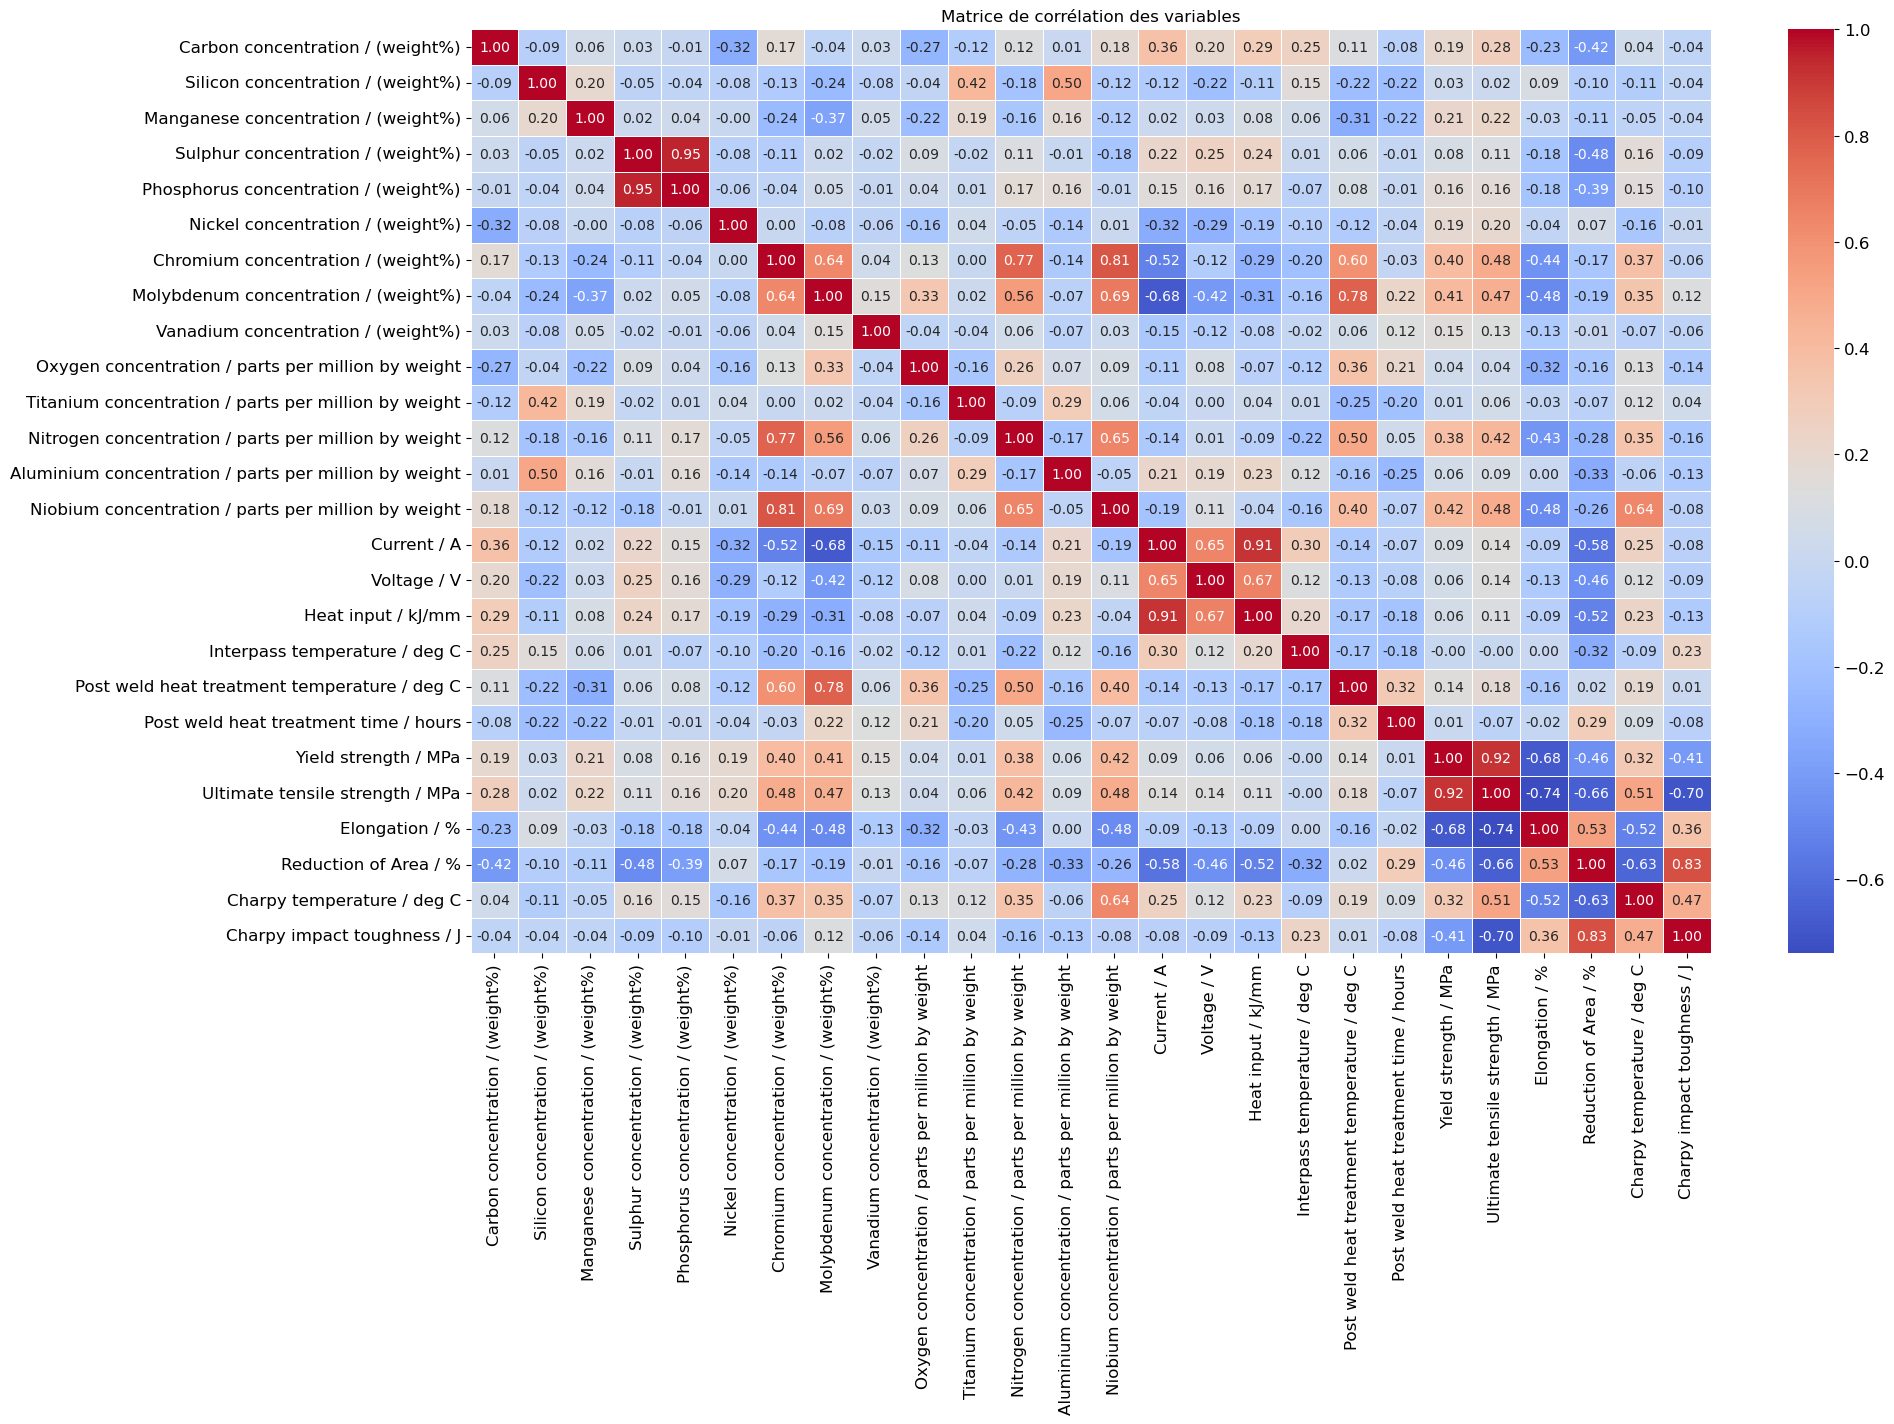

In [11]:
# Filtrer uniquement les colonnes numériques pour la matrice de corrélation
df_numeric = df_drop.select_dtypes(include=[np.number])

# Calcul de la matrice de corrélation
df_corr = df_numeric.corr()

# Seuil de corrélation
corr_threshold = 0.82
correlated_pairs = []

# Visualisation de la matrice de corrélation avec une heatmap
plt.figure(figsize=(20, 12))
sns.heatmap(df_corr, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title('Matrice de corrélation des variables')
plt.show()

Analyse des corrélations

In [12]:
# Parcourir la matrice de corrélation pour trouver les paires de variables corrélées à plus de 82%
print("Paires de variables corrélées à plus de 82% :")
for i in range(len(df_corr.columns)):
    for j in range(i):
        if abs(df_corr.iloc[i, j]) > corr_threshold:
            colname = df_corr.columns[i]
            correlated_pairs.append((df_corr.columns[j], df_corr.columns[i]))
            print(f"\n{df_corr.columns[j]} et {colname} sont fortement corrélées : {df_corr.iloc[i, j]:.2f}")

# Boucle pour compter les lignes manquantes pour chaque paire corrélée et afficher le nombre de données manquantes pour chaque colonne
for col1, col2 in correlated_pairs:
    # Nombre total de valeurs manquantes pour chaque colonne
    missing_col1_total = df_drop[col1].isnull().sum()
    missing_col2_total = df_drop[col2].isnull().sum()

    # Lignes où col1 est manquante et col2 ne l'est pas
    missing_col1 = df_drop[col1].isnull() & df_drop[col2].notnull()
    # Lignes où col2 est manquante et col1 ne l'est pas
    missing_col2 = df_drop[col2].isnull() & df_drop[col1].notnull()

    # Affichage des résultats
    print(f"Pour la paire {col1} et {col2}:")
    print(f"- {missing_col1.sum()} lignes où {col1} est manquante et {col2} non.")
    print(f"- {missing_col2.sum()} lignes où {col2} est manquante et {col1} non.")
    print(f"- {col1} a un total de {missing_col1_total} valeurs manquantes.")
    print(f"- {col2} a un total de {missing_col2_total} valeurs manquantes.")
    print("\n")


Paires de variables corrélées à plus de 82% :

Sulphur concentration / (weight%) et Phosphorus concentration / (weight%) sont fortement corrélées : 0.95

Current / A et Heat input / kJ/mm sont fortement corrélées : 0.91

Yield strength / MPa et Ultimate tensile strength / MPa sont fortement corrélées : 0.92

Reduction of Area / % et Charpy impact toughness / J sont fortement corrélées : 0.83
Pour la paire Sulphur concentration / (weight%) et Phosphorus concentration / (weight%):
- 0 lignes où Sulphur concentration / (weight%) est manquante et Phosphorus concentration / (weight%) non.
- 6 lignes où Phosphorus concentration / (weight%) est manquante et Sulphur concentration / (weight%) non.
- Sulphur concentration / (weight%) a un total de 4 valeurs manquantes.
- Phosphorus concentration / (weight%) a un total de 10 valeurs manquantes.


Pour la paire Current / A et Heat input / kJ/mm:
- 248 lignes où Current / A est manquante et Heat input / kJ/mm non.
- 0 lignes où Heat input / kJ/mm e

Nous allons donc supprimer les features suivantes d'après les résultats précédents et le nombre de valeurs manquantes qu'elles ont:
- Suppression de la feature `Current / A` de notre dataset car celle ci est trop corrélé (91%) avec `Heat input / kJ/mm` ne disposant pas de valeur manquantes.
- Suppression de la feature `Phosphorus concentration / (weight%)` de notre dataset car celle ci est trop corrélé (95%) avec `Sulphur concentration / (weight%)` disposant de moins de valeurs manquantes.

In [13]:
# Suppression des features corrélées et avec plus de valeurs manquantes
df_drop = df_drop.drop(columns=['Current / A'])
df_drop = df_drop.drop(columns=['Phosphorus concentration / (weight%)'])

Pour rappel, notre objectif étant de prédire une des sorties d’un test de traction, la valeur numérique : `Yield strength`. 

Nous nous sommes imposé le fait qu'on n’utilisera donc pas les autres features du test de traction : `UTS, Elongation, Reduction of area` pour la prédiction de Yield Strength car conceptuellement, ces features sont soit corrélées à Yield Strength, soit anecdotiques dans le cadre d'un essai de traction d'acier.

Nous allons donc supprimer ces features de notre dataset, mais avant de les supprimer nous voulions voir si une imputation plus précise ne pouvait pas être effectué grâce à ses variables si leur taux de corrélation était supérieur à 82% avec d'autres features. 

On observe d'après les résultats précédents que nous pouvons imputer les cas où :
1. `Yield strength` possède des données manquantes et que `UTS` n'en as pas (24 observations). 
2. `Charpy impact toughness / J`possède des données manquantes et que ``Reduction of Area / %`` n'en as pas (569 observations).

Une fois les deux impuations terminées nous pourront donc les supprimer définitivement. 


### 1. Inputation précise de Yield Strength

Nombre de lignes imputées pour Yield strength / MPa : 24
Valeurs manquantes après imputation pour Yield strength: 848


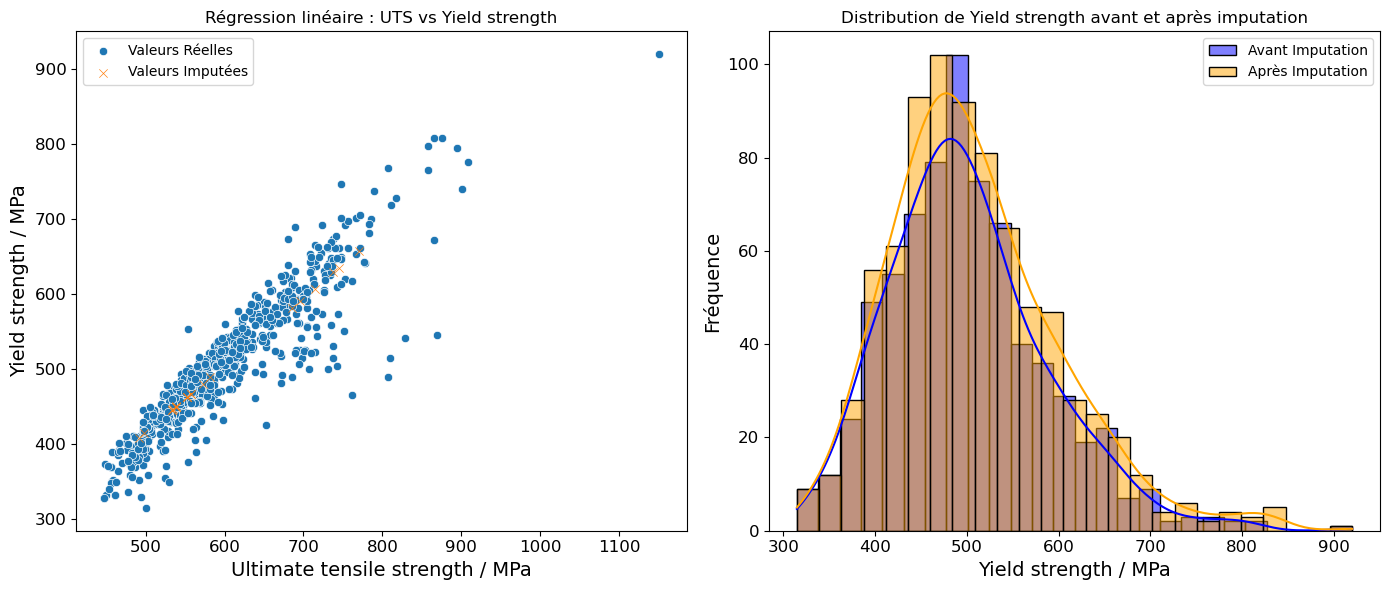

Erreur quadratique moyenne du modèle de régression : 1216.7499081269734


In [14]:
from sklearn.linear_model import LinearRegression

# Faire une copie du dataset original
df_copy = df_drop.copy()

# Séparer les données en deux ensembles : avec et sans valeurs manquantes pour Yield strength
df_with_yield = df_copy.dropna(subset=['Yield strength / MPa'])
df_without_yield = df_copy[df_copy['Yield strength / MPa'].isnull() & df_copy['Ultimate tensile strength / MPa'].notnull()]

# Filtrer les lignes avec des valeurs non manquantes pour Ultimate tensile strength / MPa
df_with_yield = df_with_yield.dropna(subset=['Ultimate tensile strength / MPa'])

# Extraire les variables indépendantes et dépendantes pour l'entraînement du modèle
X_train = df_with_yield[['Ultimate tensile strength / MPa']]
y_train = df_with_yield['Yield strength / MPa']

# Entraîner le modèle de régression linéaire
model = LinearRegression()
model.fit(X_train, y_train)

# Prédire les valeurs manquantes de Yield strength uniquement pour les 24 lignes concernées
X_missing = df_without_yield[['Ultimate tensile strength / MPa']]
y_pred = model.predict(X_missing)

# Compter les lignes avant imputation
missing_before = df_copy['Yield strength / MPa'].isnull().sum()

# Imputer les valeurs prédites dans la copie du DataFrame original
df_copy.loc[df_copy['Yield strength / MPa'].isnull() & df_copy['Ultimate tensile strength / MPa'].notnull(), 'Yield strength / MPa'] = y_pred

# Mettre à jour le DataFrame original avec les valeurs imputées
df_drop.update(df_copy)

# Compter les lignes après imputation
missing_after = df_drop['Yield strength / MPa'].isnull().sum()

# Calculer le nombre de lignes modifiées
rows_modified = missing_before - missing_after

# Afficher le nombre de lignes modifiées
print(f"Nombre de lignes imputées pour Yield strength / MPa : {rows_modified}")
print("Valeurs manquantes après imputation pour Yield strength:", df_drop['Yield strength / MPa'].isnull().sum())

# Comparaison avant/après l'imputation pour Yield strength
plt.figure(figsize=(14, 6))

# Graphique 1: Scatter plot pour visualiser la corrélation entre UTS et Yield strength
plt.subplot(1, 2, 1)
sns.scatterplot(x=df_with_yield['Ultimate tensile strength / MPa'], y=df_with_yield['Yield strength / MPa'], label='Valeurs Réelles')
sns.scatterplot(x=X_missing['Ultimate tensile strength / MPa'], y=y_pred, label='Valeurs Imputées', marker='x')
plt.title("Régression linéaire : UTS vs Yield strength")
plt.xlabel('Ultimate tensile strength / MPa')
plt.ylabel('Yield strength / MPa')
plt.legend()

# Graphique 2: Histogramme de la distribution avant/après imputation
plt.subplot(1, 2, 2)
sns.histplot(df_with_yield['Yield strength / MPa'], color='blue', label='Avant Imputation', kde=True)
sns.histplot(df_copy['Yield strength / MPa'], color='orange', label='Après Imputation', kde=True)
plt.title("Distribution de Yield strength avant et après imputation")
plt.xlabel('Yield strength / MPa')
plt.ylabel('Fréquence')
plt.legend()

plt.tight_layout()
plt.show()

# Erreur quadratique moyenne pour la performance de la régression linéaire
mse = mean_squared_error(y_train, model.predict(X_train))
print(f"Erreur quadratique moyenne du modèle de régression : {mse}")


### 2. Inputation précise de Charpy toughness

Nombre de lignes imputées pour Charpy impact toughness: 569
Valeurs manquantes après imputation pour Charpy impact toughness: 204


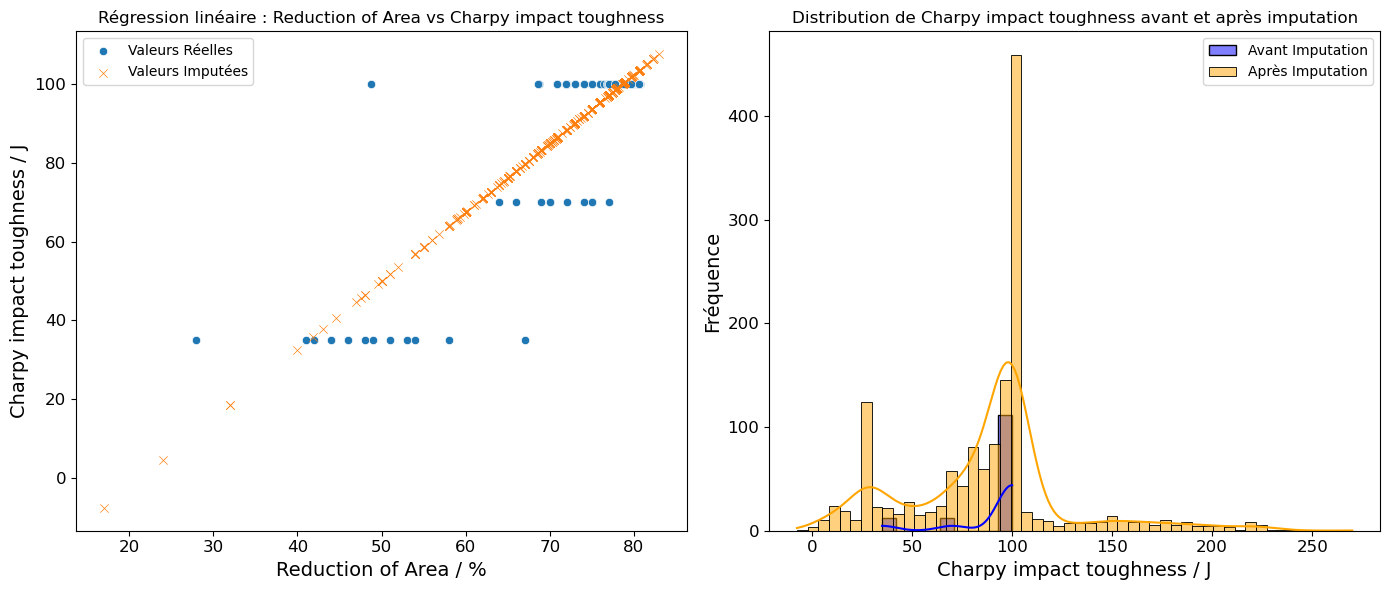

Erreur quadratique moyenne du modèle de régression : 118.06186603927442


In [15]:
# Faire une copie du dataset original
df_copy = df_drop.copy()

# Séparer les données en deux ensembles : avec et sans valeurs manquantes pour Charpy impact toughness / J
df_with_charpy = df_copy.dropna(subset=['Charpy impact toughness / J'])
df_without_charpy = df_copy[df_copy['Charpy impact toughness / J'].isnull() & df_copy['Reduction of Area / %'].notnull()]

# Filtrer les lignes avec des valeurs non manquantes pour Reduction of Area / %
df_with_charpy = df_with_charpy.dropna(subset=['Reduction of Area / %'])

# Extraire les variables indépendantes et dépendantes pour l'entraînement du modèle
X_train = df_with_charpy[['Reduction of Area / %']]
y_train = df_with_charpy['Charpy impact toughness / J']

# Entraîner le modèle de régression linéaire
model = LinearRegression()
model.fit(X_train, y_train)

# Prédire les valeurs manquantes de Charpy impact toughness uniquement pour les lignes concernées
X_missing = df_without_charpy[['Reduction of Area / %']]
y_pred = model.predict(X_missing)

# Compter les lignes avant imputation
missing_before = df_copy['Charpy impact toughness / J'].isnull().sum()

# Imputer les valeurs prédites dans la copie du DataFrame original
df_copy.loc[df_copy['Charpy impact toughness / J'].isnull() & df_copy['Reduction of Area / %'].notnull(), 'Charpy impact toughness / J'] = y_pred

# Mettre à jour le DataFrame original avec les valeurs imputées
df_drop.update(df_copy)

# Compter les lignes après imputation
missing_after = df_drop['Charpy impact toughness / J'].isnull().sum()

# Calculer le nombre de lignes modifiées
rows_modified = missing_before - missing_after

# Afficher le nombre de lignes modifiées
print(f"Nombre de lignes imputées pour Charpy impact toughness: {rows_modified}")

# Confirmer qu'il n'y a plus de valeurs manquantes pour Charpy impact toughness / J dans les lignes concernées
print("Valeurs manquantes après imputation pour Charpy impact toughness:", df_drop['Charpy impact toughness / J'].isnull().sum())

plt.figure(figsize=(14, 6))

# Graphique 1: Scatter plot pour visualiser la corrélation entre Reduction of Area et Charpy impact toughness
plt.subplot(1, 2, 1)
sns.scatterplot(x=df_with_charpy['Reduction of Area / %'], y=df_with_charpy['Charpy impact toughness / J'], label='Valeurs Réelles')
sns.scatterplot(x=X_missing['Reduction of Area / %'], y=y_pred, label='Valeurs Imputées', marker='x')
plt.title("Régression linéaire : Reduction of Area vs Charpy impact toughness")
plt.xlabel('Reduction of Area / %')
plt.ylabel('Charpy impact toughness / J')
plt.legend()

# Graphique 2: Histogramme de la distribution avant/après imputation
plt.subplot(1, 2, 2)
sns.histplot(df_with_charpy['Charpy impact toughness / J'], color='blue', label='Avant Imputation', kde=True)
sns.histplot(df_copy['Charpy impact toughness / J'], color='orange', label='Après Imputation', kde=True)
plt.title("Distribution de Charpy impact toughness avant et après imputation")
plt.xlabel('Charpy impact toughness / J')
plt.ylabel('Fréquence')
plt.legend()

plt.tight_layout()
plt.show()

# Erreur quadratique moyenne pour la performance de la régression linéaire
mse = mean_squared_error(y_train, model.predict(X_train))
print(f"Erreur quadratique moyenne du modèle de régression : {mse}")


### Suppression des features à faible variance
L'élimination des features ayant une variance faible (inférieure à 0.01) permet de réduire la complexité du modèle en supprimant les variables non informatives. Cela améliore l'efficacité et les performances du modèle en se concentrant sur les features réellement utiles, tout en évitant le surapprentissage et en accélérant les temps de calcul.


In [16]:
from sklearn.feature_selection import VarianceThreshold

# Seuil de variance
variance_threshold = 0.01

# Sélectionner uniquement les colonnes numériques
df_numeric = df_drop.select_dtypes(include=[np.number])

# Appliquer la méthode VarianceThreshold pour éliminer les features avec une faible variance
selector = VarianceThreshold(threshold=variance_threshold)
selector.fit(df_numeric)
low_variance_columns = df_numeric.columns[~selector.get_support()]

# Afficher les colonnes avec une variance inférieure au seuil
print(f"Les colonnes avec une variance inférieure à {variance_threshold} et qui n'apportent rien au modèle :\n{low_variance_columns.tolist()}")


Les colonnes avec une variance inférieure à 0.01 et qui n'apportent rien au modèle :
['Carbon concentration / (weight%)', 'Sulphur concentration / (weight%)']


In [17]:
#Supprimer les colonnes avec une variance inférieure au seuil
df_drop = df_drop.drop(columns=low_variance_columns)

### Supression des autres features des tests de traction

Nous pouvons maintenant supprimer les autres features du test de traction : `UTS`, `Elongation`, `Reduction of area`!

In [18]:
# Drop de weld ID
df_drop = df_drop.drop(columns=['Weld ID'])

# Creation de with et withou target pour les données
df_drop_with_target = df_drop.drop(columns=['Ultimate tensile strength / MPa', 'Elongation / %', 'Reduction of Area / %'])
# Supprimer les colonnes UTS, Elongation, Reduction of area
df_drop_without_target = df_drop.drop(columns=['Ultimate tensile strength / MPa', 'Elongation / %', 'Reduction of Area / %', 'Yield strength / MPa'])
#Taille du dataset après nettoyage
print("Dimensions of dropped data:",df_drop.shape)

Dimensions of dropped data: (1652, 25)


## Conclusion du traitement global

In [19]:
# Colonnes restantes après le nettoyage global
df_drop_without_target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1652 entries, 0 to 1651
Data columns (total 21 columns):
 #   Column                                                 Non-Null Count  Dtype  
---  ------                                                 --------------  -----  
 0   Silicon concentration / (weight%)                      1652 non-null   float64
 1   Manganese concentration / (weight%)                    1652 non-null   float64
 2   Nickel concentration / (weight%)                       697 non-null    float64
 3   Chromium concentration / (weight%)                     784 non-null    float64
 4   Molybdenum concentration / (weight%)                   793 non-null    float64
 5   Vanadium concentration / (weight%)                     928 non-null    float64
 6   Oxygen concentration / parts per million by weight     1256 non-null   float64
 7   Titanium concentration / parts per million by weight   935 non-null    float64
 8   Nitrogen concentration / parts per million by we

In [20]:
numeric_df_drop = df_drop_without_target.select_dtypes(include=[np.number])

# Calcul des bornes de l'intervalle interquartile (IQR)
Q1 = numeric_df_drop.quantile(0.25)
Q3 = numeric_df_drop.quantile(0.75)
IQR = Q3 - Q1

# Définir les bornes inférieures et supérieures pour détecter les outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Compter le nombre d'outliers pour chaque colonne numérique
df_aligned, lower_bound_aligned = numeric_df_drop.align(lower_bound, axis=1, copy=False)
_, upper_bound_aligned = numeric_df_drop.align(upper_bound, axis=1, copy=False)
outliers = ((df_aligned < lower_bound_aligned) | (df_aligned > upper_bound_aligned)).sum()

# Ajouter le nombre de valeurs manquantes et le pourcentage de valeurs manquantes pour les colonnes numériques
missing_values = numeric_df_drop.isnull().sum()
missing_percentage = (missing_values / len(df_drop_without_target)) * 100

numeric_summary = pd.DataFrame({
    '1er quartile': Q1,
    'Médiane': numeric_df_drop.median(),
    'Moyenne': numeric_df_drop.mean(),
    '3ème quartile': Q3,
    'Écart-type': numeric_df_drop.std(),
    'Min': numeric_df_drop.min(),
    'Max': numeric_df_drop.max(),
    'Nombre d\'outliers': outliers,
    'Nombre de valeurs manquantes': missing_values,
    'Pourcentage de valeurs manquantes': missing_percentage
})

print("Statistiques pour les colonnes numériques :")
numeric_summary


Statistiques pour les colonnes numériques :


1er quartile     Médiane  \
Silicon concentration / (weight%)                       0.270000    0.320000   
Manganese concentration / (weight%)                     0.940000    1.270000   
Nickel concentration / (weight%)                        0.000000    0.067000   
Chromium concentration / (weight%)                      0.000000    0.530000   
Molybdenum concentration / (weight%)                    0.000000    0.340000   
Vanadium concentration / (weight%)                      0.000500    0.009500   
Oxygen concentration / parts per million by weight    370.000000  423.000000   
Titanium concentration / parts per million by w...     30.000000   42.000000   
Nitrogen concentration / parts per million by w...     72.000000   83.000000   
Aluminium concentration / parts per million by ...      5.000000   44.000000   
Niobium concentration / parts per million by we...      5.000000    5.000000   
Voltage / V                                            21.000000   21.000000   
Heat input / kJ/mm                                      1.000000    1.000000   
Interpass temperature / deg C                         200.000000  200.000000   
Post weld heat treatment temperature / deg C            0.000000  250.000000   
Post weld heat treatment time / hours                   0.000000    2.000000   
Charpy temperature / deg C                            -60.000000  -40.000000   
Charpy impact toughness / J                            69.446382   97.084815   

                                                       Moyenne  3ème quartile  \
Silicon concentration / (weight%)                     0.328577          0.360   
Manganese concentration / (weight%)                   1.202821          1.440   
Nickel concentration / (weight%)                      0.415034          0.260   
Chromium concentration / (weight%)                    2.101273          2.300   
Molybdenum concentration / (weight%)                  0.479172          1.010   
Vanadium concentration / (weight%)                    0.097379          0.044   
Oxygen concentration / parts per million by weight  441.967357        471.000   
Titanium concentration / parts per million by w...   80.564342        100.000   
Nitrogen concentration / parts per million by w...  113.378698        106.500   
Aluminium concentration / parts per million by ...  102.347227        150.000   
Niobium concentration / parts per million by we...  134.035904        200.000   
Voltage / V                                          27.607379         30.000   
Heat input / kJ/mm                                    1.700987          2.000   
Interpass temperature / deg C                       204.902726        200.000   
Post weld heat treatment temperature / deg C        304.674192        580.000   
Post weld heat treatment time / hours                 5.049652         10.000   
Charpy temperature / deg C                          -34.606371        -17.500   
Charpy impact toughness / J                          87.479996        100.000   

                                                    Écart-type         Min  \
Silicon concentration / (weight%)                     0.112455    0.040000   
Manganese concentration / (weight%)                   0.382137    0.270000   
Nickel concentration / (weight%)                      0.786951    0.000000   
Chromium concentration / (weight%)                    3.026548    0.000000   
Molybdenum concentration / (weight%)                  0.477404    0.000000   
Vanadium concentration / (weight%)                    0.492889    0.000000   
Oxygen concentration / parts per million by weight  147.483825  132.000000   
Titanium concentration / parts per million by w...   97.086353    0.000000   
Nitrogen concentration / parts per million by w...   95.902889   21.000000   
Aluminium concentration / parts per million by ...  141.474043    0.004000   
Niobium concentration / parts per million by we...  228.686640    0.000000   
Voltage / V                                          12

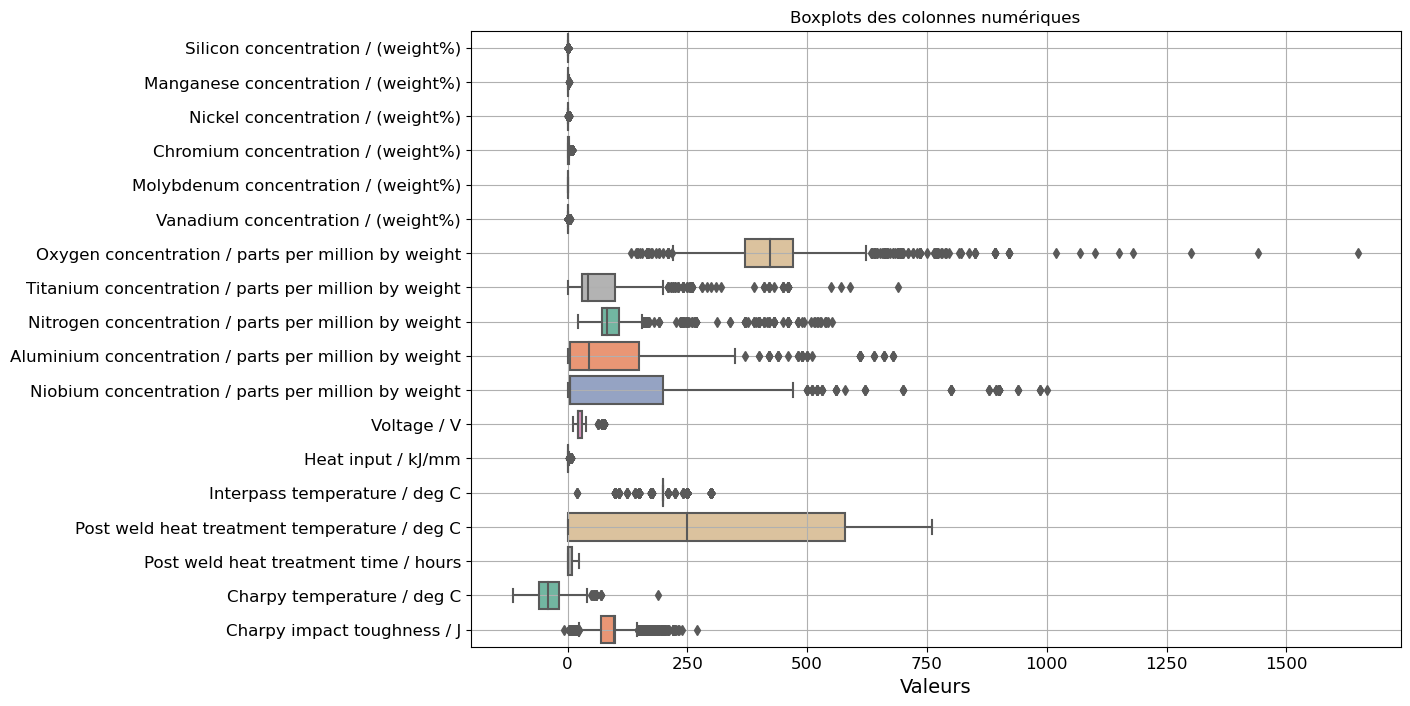

In [21]:
numeric_df_drop = df_drop_without_target.select_dtypes(include=[np.number])

# Fonction pour tracer les boxplots des colonnes numériques
def plot_boxplots(df):
    plt.figure(figsize=(12, 8))
    sns.boxplot(data=df, orient='h', palette="Set2")
    plt.title('Boxplots des colonnes numériques')
    plt.xlabel('Valeurs')
    plt.grid(True)
    plt.show()

plot_boxplots(numeric_df_drop)


In [22]:
# Calcul des statistiques pour les colonnes catégoriques
categorical_df_drop = df_drop_without_target.select_dtypes(include=[object])
missing_values_cat = categorical_df_drop.isnull().sum()
missing_percentage_cat = (missing_values_cat / len(df_drop_without_target)) * 100

categorical_summary = pd.DataFrame({
    'Type': categorical_df_drop.dtypes,
    'Nombre de valeurs uniques': categorical_df_drop.nunique(),
    'Valeur la plus fréquente': categorical_df_drop.mode().iloc[0],
    'Fréquence de la valeur la plus fréquente': categorical_df_drop.apply(lambda x: x.value_counts().max()),
    'Nombre de valeurs manquantes': missing_values_cat,
    'Pourcentage de valeurs manquantes': missing_percentage_cat
})
print("\nStatistiques pour les colonnes catégoriques :")
categorical_summary



Statistiques pour les colonnes catégoriques :


Type  Nombre de valeurs uniques  \
AC or DC                        object                          2   
Electrode positive or negative  object                          3   
Type of weld                    object                          8   

                               Valeur la plus fréquente  \
AC or DC                                             DC   
Electrode positive or negative                        +   
Type of weld                                        MMA   

                                Fréquence de la valeur la plus fréquente  \
AC or DC                                                            1395   
Electrode positive or negative                                      1451   
Type of weld                                                        1180   

                                Nombre de valeurs manquantes  \
AC or DC                                                 215   
Electrode positive or negative                           156   
Type of weld                                               0   

                                Pourcentage de valeurs manquantes  
AC or DC                                                13.014528  
Electrode positive or negative                           9.443099  
Type of weld                                             0.000000

## Représentation des features
Affichage des histogrammes des features pour avoir un aperçu de la dispersion

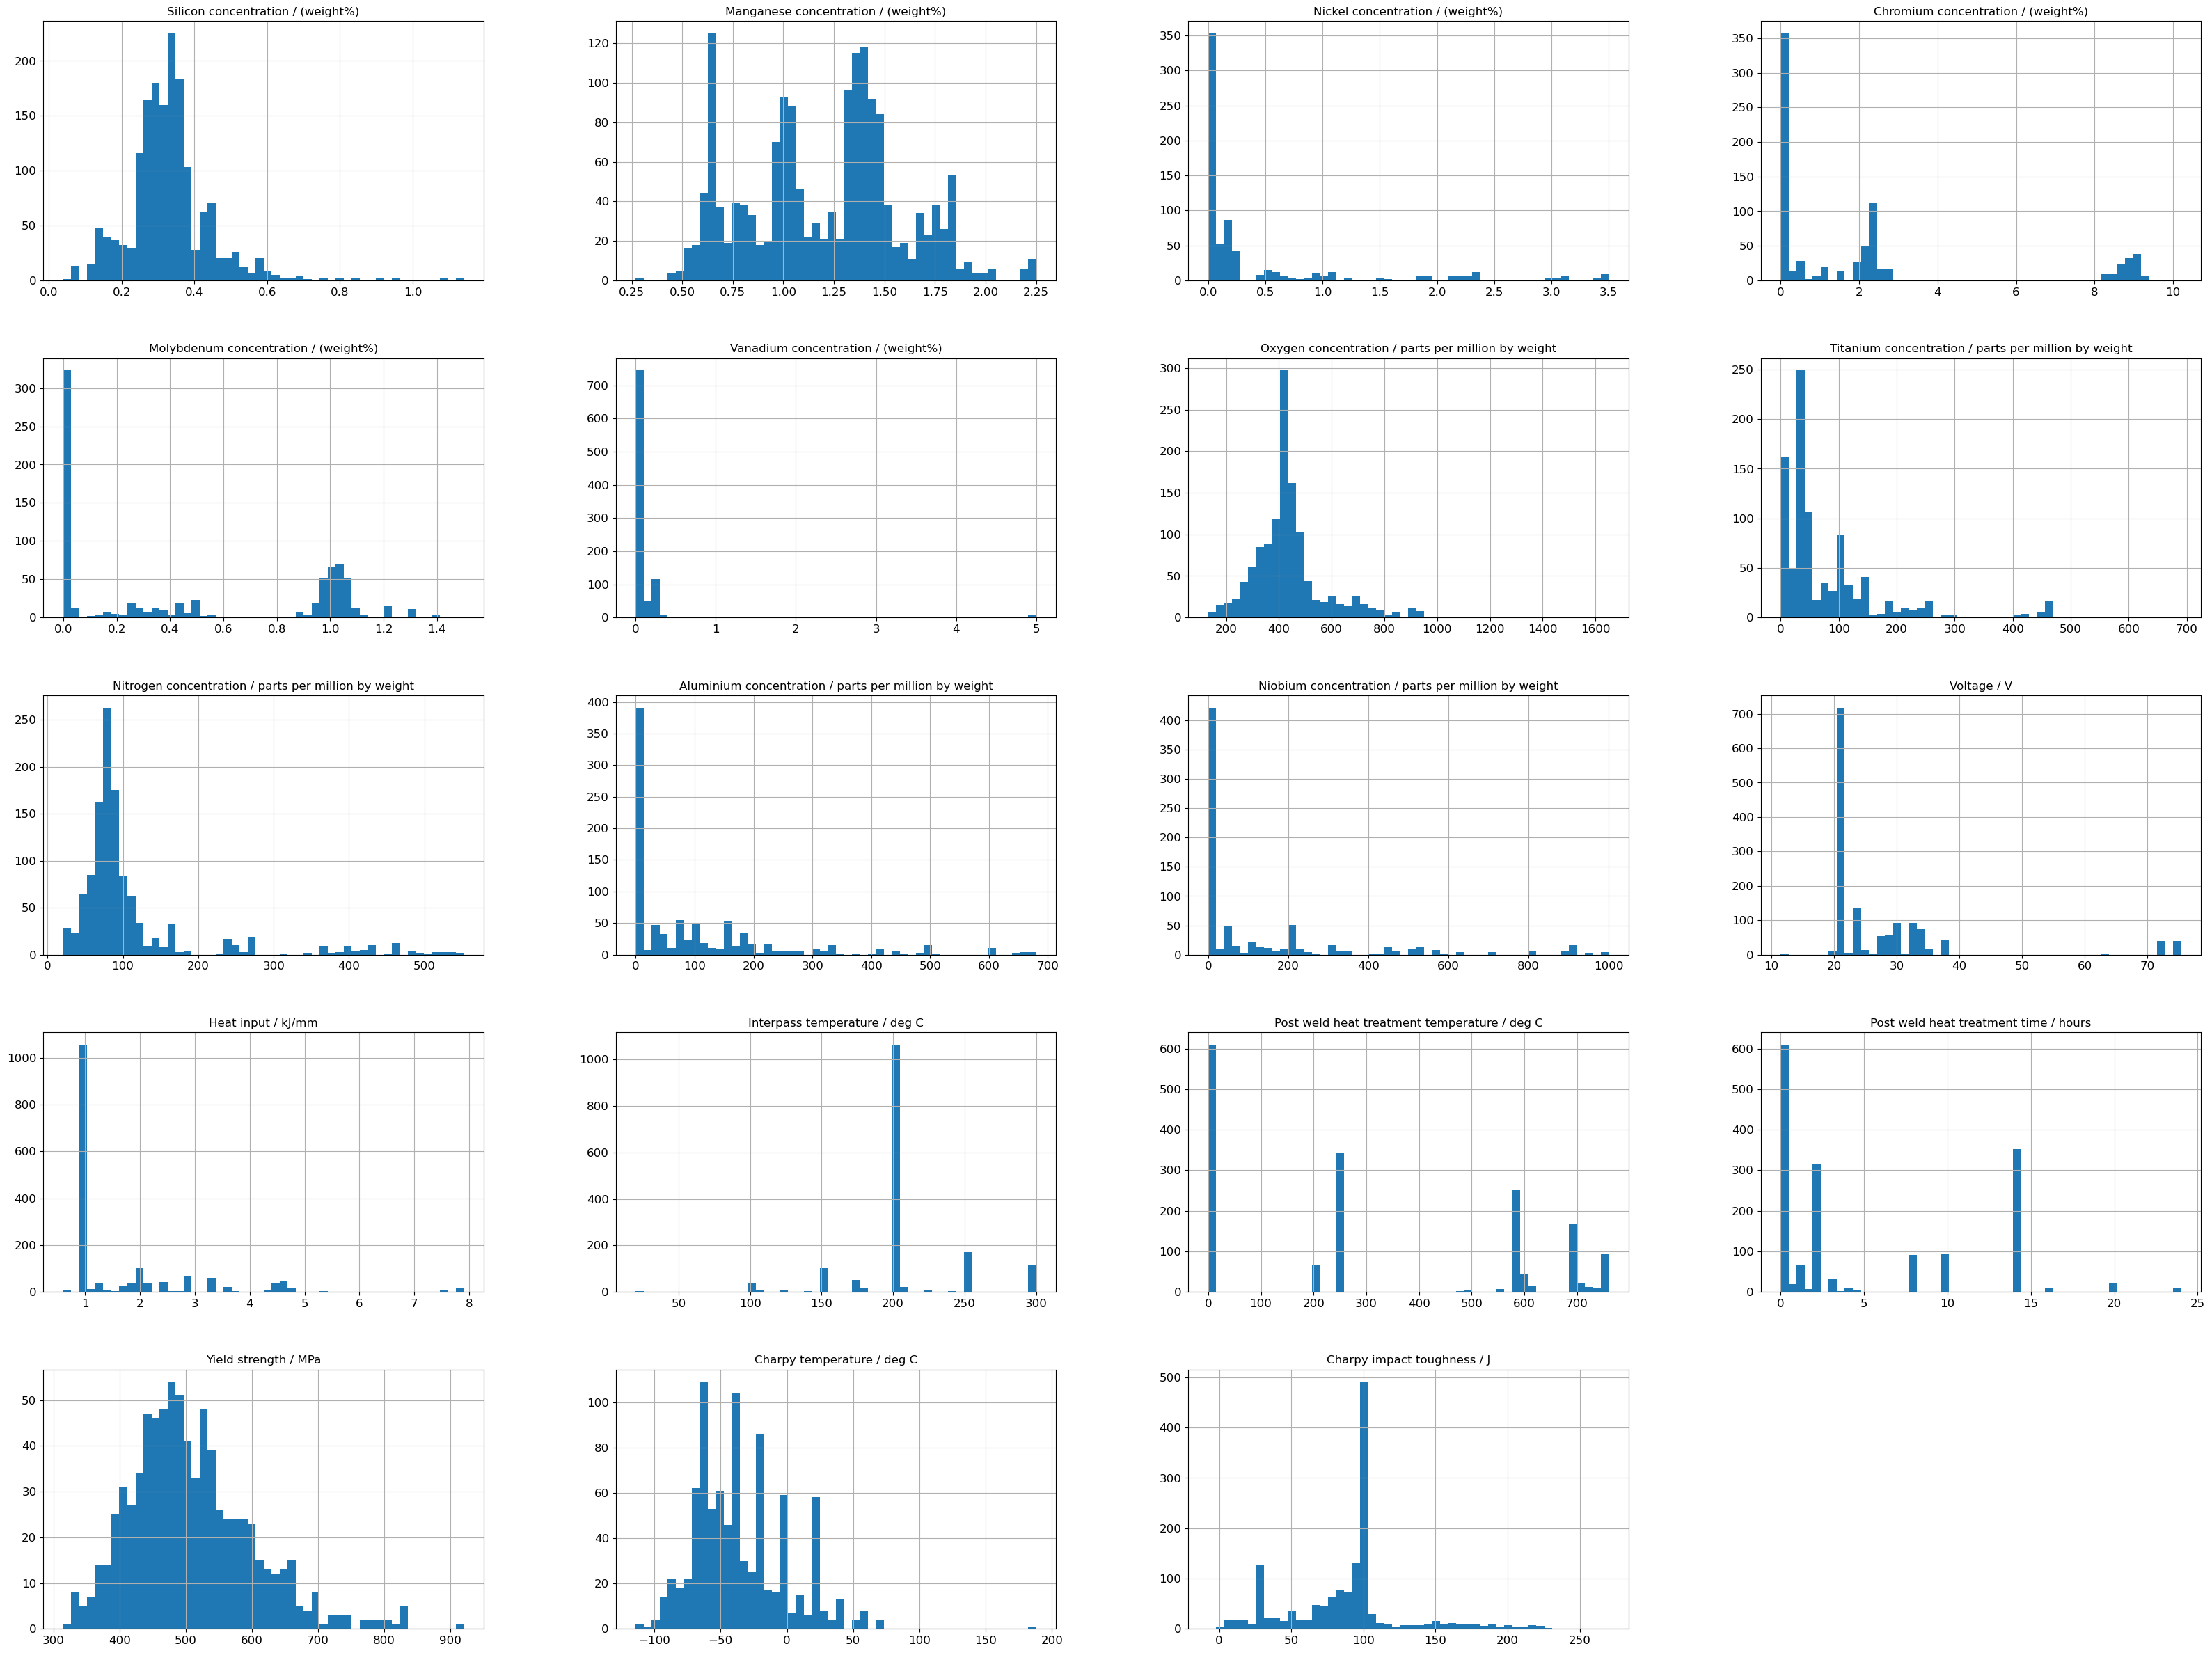

In [23]:
df_drop_with_target.hist(bins=50, figsize=(40, 30))
plt.show()

# 2. Imputations

A ce stade du prétraitement, il reste 20 features, qui peuvent posséder des données manquantes.

L'imputation de ces features est menée en deux temps avec deux méthodes différentes : 

-	Imputation pour les variables catégorielles par la mode
-   Imputation pour les variables numériques par différents algos

Afin d'avoir plus de certitudes sur la meilleur méthode d'imputation à choisir, nous essayons plusieurs méthodes que nous sommettrons aux algos de ML par la suite

Les méthodes d'imputation numériques retenues sont : 
-   KNN
-   Régression (Iterative Imputer)
-   MICE (modélisation itérative tenant compte des relations entre variables)
-   Médiane
-   Moyenne

Chaque méthode est appliquée de manière systématique sur toutes les colonnes numériques générant ainsi plusieurs dataset différents que nous utiliserons pour évaluer les performances avec différents algorithmes.

Une méthode est aussi déployée pour ajuster la méthode d'imputation en fonction de la distribution de chaque feature, commé détaillé ci-dessous.

| Méthode	| Caractéristiques | Features |
|----------  | ------------- | ---------------- |
| Imputation par la médiane | Pour distributions asymétriques avec de nombreux outliers. C’est une mesure robuste, pas influencée par les valeurs extrêmes et sans biais | Nickel et Vanadium |
| Imputation par la moyenne | Pour distributions symétriques, avec peu d'outliers et peu de valeurs manquantes | Post weld heat treatment temperature et time |
| Imputation par KNN | Pour distributions avec taux élevé de valeurs manquantes et des similitudes avec d'autres variables. C’est une mesure robuste aux outliers | Charpy temperature et  impact toughness.
| Imputation par régression	| Pour distributions avec un fort taux de valeurs manquantes et une corrélation élevée avec d’autres variables. C’est une mesure qui permet de mieux capturer les relations linéaires entre les variables | Chromium et Molybdenium





## 2.1 Imputations avec mode pour les variables catégorielles
Imputation par la mode (valeur la plus fréquente), assurant ainsi la cohérence avec la majorité des données tout en minimisant l'introduction de biais.

Une seconde approche plus précise a été réalisée en fonction de la distribution des colonnes (outliers, écart type, distribution symétrique ou asymétrique) et de leur corrélation avec d’autres variables.
Nous utilisons plusieurs méthodes sélectionnées précisément pour correspondre le mieux au profil des features.


In [24]:
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

# Copie du dataset
df_copy = df_drop_with_target.copy()

# Séparation des colonnes numériques et catégorielles
numeric_cols = df_copy.select_dtypes(include=[np.number]).columns
categorical_cols = df_copy.select_dtypes(include=[object]).columns

# Imputation par mode pour les colonnes catégorielles
df_copy[categorical_cols] = df_copy[categorical_cols].apply(lambda x: x.fillna(x.mode()[0]), axis=0)

# Encodage des variables catégorielles ici car nécessaire pour Semi-supervisé
df_copy_encoded = pd.get_dummies(df_copy, drop_first=True)

# 1. Imputation par KNN pour les colonnes numériques
knn_imputer = KNNImputer(n_neighbors=5)
df_knn_imputed = df_copy_encoded.copy()
df_knn_imputed[numeric_cols] = knn_imputer.fit_transform(df_copy_encoded[numeric_cols])

# 2. Imputation par régression (IterativeImputer avec modèle par défaut)
regression_imputer = IterativeImputer(estimator=LinearRegression(), random_state=0)
df_regression_imputed = df_copy_encoded.copy()
df_regression_imputed[numeric_cols] = regression_imputer.fit_transform(df_copy_encoded[numeric_cols])

# 3. Imputation par MICE (IterativeImputer sans spécifier de modèle, par défaut c'est bayésien)
mice_imputer = IterativeImputer(random_state=0)
df_mice_imputed = df_copy_encoded.copy()
df_mice_imputed[numeric_cols] = mice_imputer.fit_transform(df_copy_encoded[numeric_cols])

# 4. Imputation par la médiane pour les colonnes numériques
df_median_imputed = df_copy_encoded.copy()
df_median_imputed[numeric_cols] = df_median_imputed[numeric_cols].apply(lambda x: x.fillna(x.median()), axis=0)

# 5. Imputation par la moyenne pour les colonnes numériques
df_mean_imputed = df_copy_encoded.copy()
df_mean_imputed[numeric_cols] = df_mean_imputed[numeric_cols].apply(lambda x: x.fillna(x.mean()), axis=0)

### 6. Imputation plus précise selon les distributions des données

# 6.1. Imputation par la médiane pour certaines colonnes avec des outliers et distributions asymétriques
df_specific_median_imputed = df_copy_encoded.copy()
median_columns = ['Voltage / V', 
'Nitrogen concentration / parts per million by weight', 
'Interpass temperature / deg C',
'Vanadium concentration / (weight%)',
'Nickel concentration / (weight%)',
'Aluminium concentration / parts per million by weight']
df_specific_median_imputed[median_columns] = df_specific_median_imputed[median_columns].apply(lambda x: x.fillna(x.median()), axis=0)

# 6.2. Imputation par la moyenne pour les colonnes avec une distribution plus symétrique et peu de valeurs manquantes
df_specific_mean_imputed = df_specific_median_imputed.copy()  # Continue avec la copie précédente
mean_columns = ['Post weld heat treatment temperature / deg C', 'Post weld heat treatment time / hours']
df_specific_mean_imputed[mean_columns] = df_specific_mean_imputed[mean_columns].apply(lambda x: x.fillna(x.mean()), axis=0)

# 6.3. Imputation par KNN pour les colonnes avec de nombreuses valeurs manquantes et résistantes aux outliers
df_specific_knn_imputed = df_specific_mean_imputed.copy()  # Continue avec la copie précédente
knn_columns = ['Charpy temperature / deg C', 'Charpy impact toughness / J']
knn_imputer = KNNImputer(n_neighbors=5)
df_specific_knn_imputed[knn_columns] = knn_imputer.fit_transform(df_specific_knn_imputed[knn_columns])

# 6.4. Imputation par régression pour certaines colonnes ayant une relation linéaire avec d'autres variables
df_specific_regression_imputed = df_specific_knn_imputed.copy()  # Continue avec la copie précédente
regression_columns = [
    'Yield strength / MPa', 
    'Chromium concentration / (weight%)',
    'Molybdenum concentration / (weight%)', 
    'Oxygen concentration / parts per million by weight', 
    'Titanium concentration / parts per million by weight', 
    'Niobium concentration / parts per million by weight']
regression_imputer = IterativeImputer(estimator=LinearRegression(), random_state=0)
df_specific_regression_imputed[regression_columns] = regression_imputer.fit_transform(df_specific_regression_imputed[regression_columns])

# Justifications:
# - La médiane est utilisée pour les colonnes avec des distributions asymétriques ou avec beaucoup d'outliers.
# - La moyenne est utilisée pour les colonnes avec peu d'outliers et une distribution plus régulière.
# - KNN est utilisé pour les colonnes avec beaucoup de valeurs manquantes et des outliers, car il est plus robuste.
# - La régression est appliquée pour des colonnes ayant potentiellement une relation linéaire avec d'autres variables.

#7 semi supervise
df_specific_semi_supervise = df_specific_knn_imputed.copy()  # Continue avec la copie précédente
regression_columns = [
    'Chromium concentration / (weight%)',
    'Molybdenum concentration / (weight%)', 
    'Oxygen concentration / parts per million by weight', 
    'Titanium concentration / parts per million by weight', 
    'Niobium concentration / parts per million by weight']
regression_imputer = IterativeImputer(estimator=LinearRegression(), random_state=0)
df_specific_semi_supervise[regression_columns] = regression_imputer.fit_transform(df_specific_regression_imputed[regression_columns])
df_specific_semi_supervise2 = df_specific_semi_supervise

def dsicretisation(x):
    if np.isnan(x):
        return np.nan
    elif x < y.mean():
        return 0
    else:
        return 1

y = df_specific_semi_supervise['Yield strength / MPa']
df_specific_semi_supervise['Yield strength / MPa'] = y.apply(dsicretisation)

### Création des datasets "df_target" et "df_without_target"
df_target_mode_knn = df_knn_imputed['Yield strength / MPa']
df_without_target_mode_knn = df_knn_imputed.drop(columns=['Yield strength / MPa'])

df_target_mode_regression = df_regression_imputed['Yield strength / MPa']
df_without_target_mode_regression = df_regression_imputed.drop(columns=['Yield strength / MPa'])

df_target_mode_mice = df_mice_imputed['Yield strength / MPa']
df_without_target_mode_mice = df_mice_imputed.drop(columns=['Yield strength / MPa'])

df_target_mode_median = df_median_imputed['Yield strength / MPa']
df_without_target_mode_median = df_median_imputed.drop(columns=['Yield strength / MPa'])

df_target_mode_mean = df_mean_imputed['Yield strength / MPa']
df_without_target_mode_mean = df_mean_imputed.drop(columns=['Yield strength / MPa'])

# 6. Méthode plus précise selon les distributions des données
df_target_mode_specific = df_specific_regression_imputed['Yield strength / MPa']
df_without_target_mode_specific = df_specific_regression_imputed.drop(columns=['Yield strength / MPa'])

#7. Semi-supervisé
df_target_mode_semi_supervise = df_specific_semi_supervise['Yield strength / MPa']
df_without_target_mode_semi_supervise = df_specific_semi_supervise.drop(columns=['Yield strength / MPa'])

c:\Users\Gabriel\anaconda3\Lib\site-packages\sklearn\impute\_iterative.py:796: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
c:\Users\Gabriel\anaconda3\Lib\site-packages\sklearn\impute\_iterative.py:796: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
c:\Users\Gabriel\anaconda3\Lib\site-packages\sklearn\impute\_iterative.py:796: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


## 2.2 Imputations par KNN sur les variables catégorielles

Une imputation par KNN est également réalisée sur les variables catégorielles.



In [25]:
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression
# Copie du dataset
df_copy = df_drop_with_target.copy()

# Séparation des colonnes numériques et catégorielles
numeric_cols = df_copy.select_dtypes(include=[np.number]).columns
categorical_cols = df_copy.select_dtypes(include=[object]).columns

# Imputation par KNN pour les colonnes catégorielles
knn_imputer_categorical = KNNImputer(n_neighbors=5)
df_copy[categorical_cols] = df_copy[categorical_cols].apply(lambda x: pd.factorize(x)[0])  # Transforme les catégories en numériques temporaires
df_copy[categorical_cols] = knn_imputer_categorical.fit_transform(df_copy[categorical_cols])

# 1. Imputation KNN pour les colonnes numériques (en maintenant les données catégorielles imputées par KNN)
knn_imputer_numeric = KNNImputer(n_neighbors=5)
df_knn_imputed = df_copy.copy()
df_knn_imputed[numeric_cols] = knn_imputer_numeric.fit_transform(df_copy[numeric_cols])

# 2. Imputation par régression (IterativeImputer) pour les colonnes numériques après KNN sur catégorielles
regression_imputer_numeric = IterativeImputer(estimator=LinearRegression(), random_state=0)
df_regression_imputed = df_copy.copy()
df_regression_imputed[numeric_cols] = regression_imputer_numeric.fit_transform(df_copy[numeric_cols])

# 3. Imputation par MICE pour les colonnes numériques après KNN sur catégorielles
mice_imputer_numeric = IterativeImputer(random_state=0)
df_mice_imputed = df_copy.copy()
df_mice_imputed[numeric_cols] = mice_imputer_numeric.fit_transform(df_copy[numeric_cols])

# 4. Imputation par la médiane pour les colonnes numériques
df_median_imputed = df_copy.copy()
df_median_imputed[numeric_cols] = df_median_imputed[numeric_cols].apply(lambda x: x.fillna(x.median()), axis=0)

# 5. Imputation par la moyenne pour les colonnes numériques
df_mean_imputed = df_copy.copy()
df_mean_imputed[numeric_cols] = df_mean_imputed[numeric_cols].apply(lambda x: x.fillna(x.mean()), axis=0)

# Création des datasets "df_target" et "df_without_target"
df_target_knn_knn = df_knn_imputed['Yield strength / MPa']
df_without_target_knn_knn = df_knn_imputed.drop(columns=['Yield strength / MPa'])

df_target_knn_regression = df_regression_imputed['Yield strength / MPa']
df_without_target_knn_regression = df_regression_imputed.drop(columns=['Yield strength / MPa'])

df_target_knn_mice = df_mice_imputed['Yield strength / MPa']
df_without_target_knn_mice = df_mice_imputed.drop(columns=['Yield strength / MPa'])

df_target_knn_median = df_median_imputed['Yield strength / MPa']
df_without_target_knn_median = df_median_imputed.drop(columns=['Yield strength / MPa'])

df_target_knn_mean = df_mean_imputed['Yield strength / MPa']
df_without_target_knn_mean = df_mean_imputed.drop(columns=['Yield strength / MPa'])

c:\Users\Gabriel\anaconda3\Lib\site-packages\sklearn\impute\_iterative.py:796: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
c:\Users\Gabriel\anaconda3\Lib\site-packages\sklearn\impute\_iterative.py:796: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


# 3. REDUCTION DE DIMENSION

L'objectif principal de cette étape est de simplifier l'ensemble de caractéristiques tout en maximisant la variance expliquée dans la variable cible `Yield strength / MPa`.

La méthode retenue pour réaliser la réduction de dimensions est PLS.

--- Traitement de KNN ---
Longueur du DataFrame après PLS pour KNN : (1652, 11)


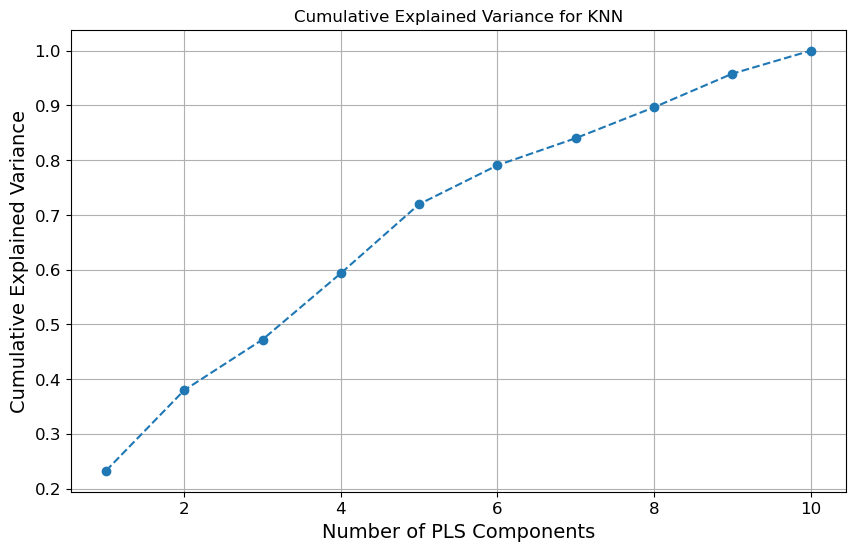

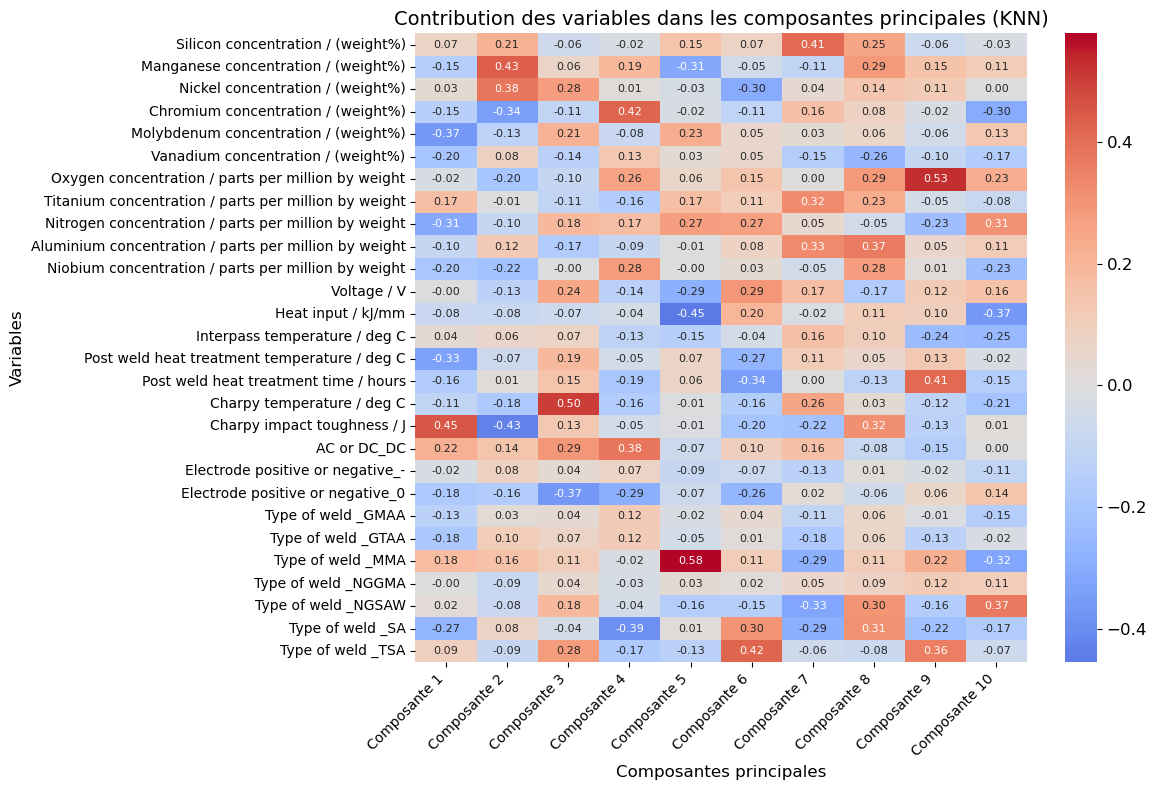

--- Traitement de Regression ---
Longueur du DataFrame après PLS pour Regression : (1652, 11)


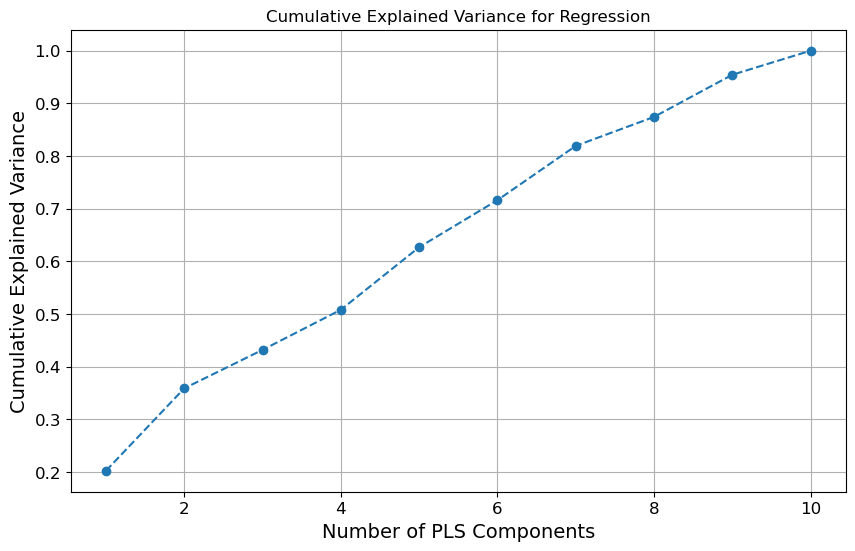

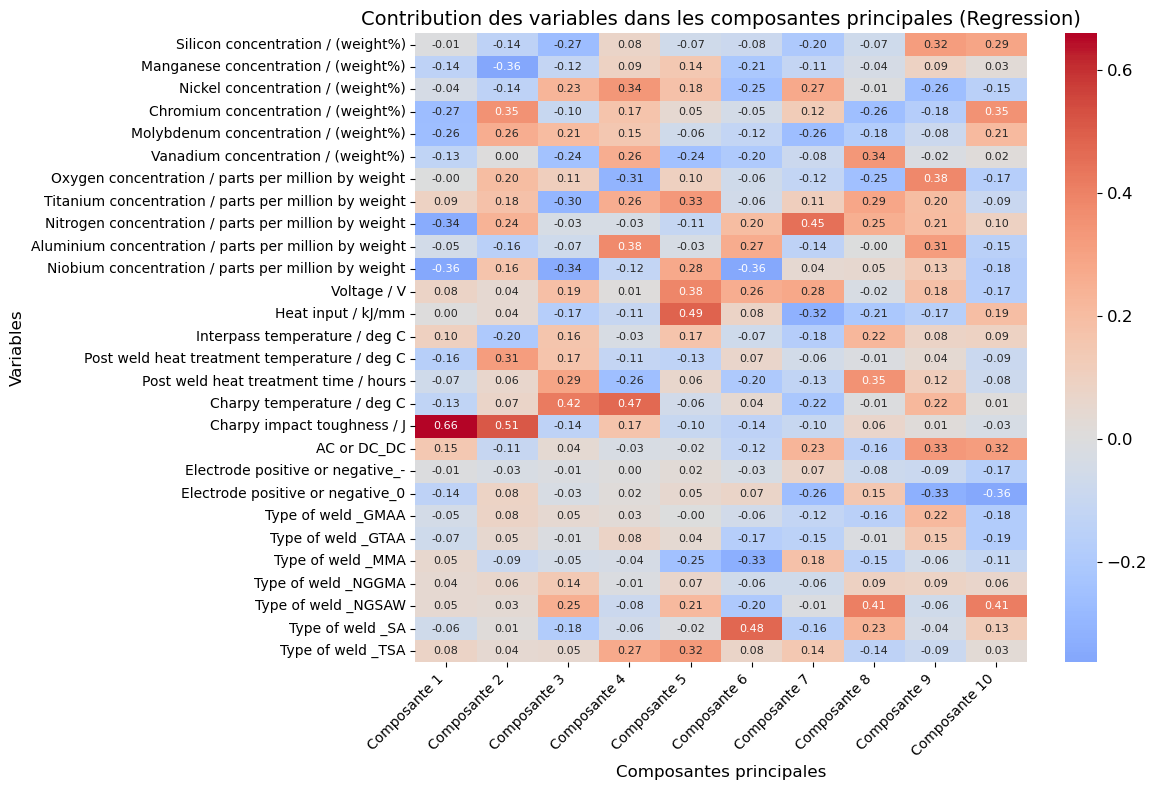

--- Traitement de MICE ---
Longueur du DataFrame après PLS pour MICE : (1652, 11)


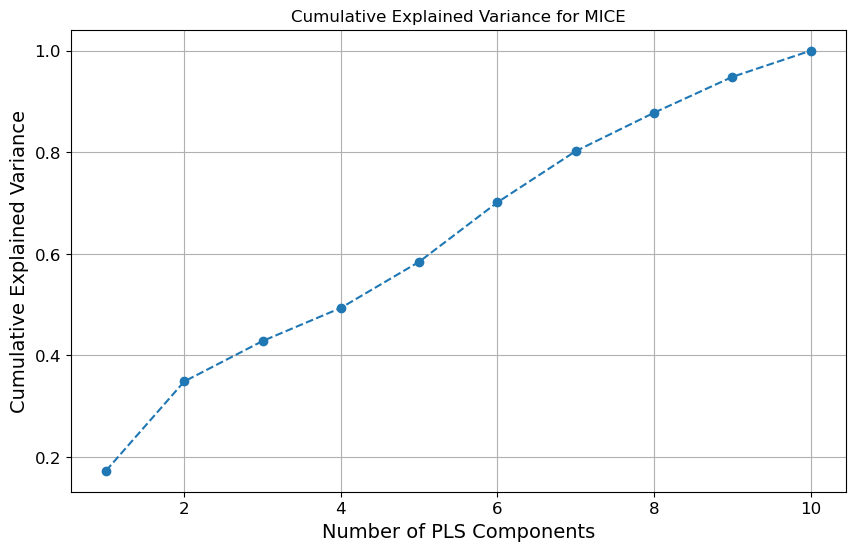

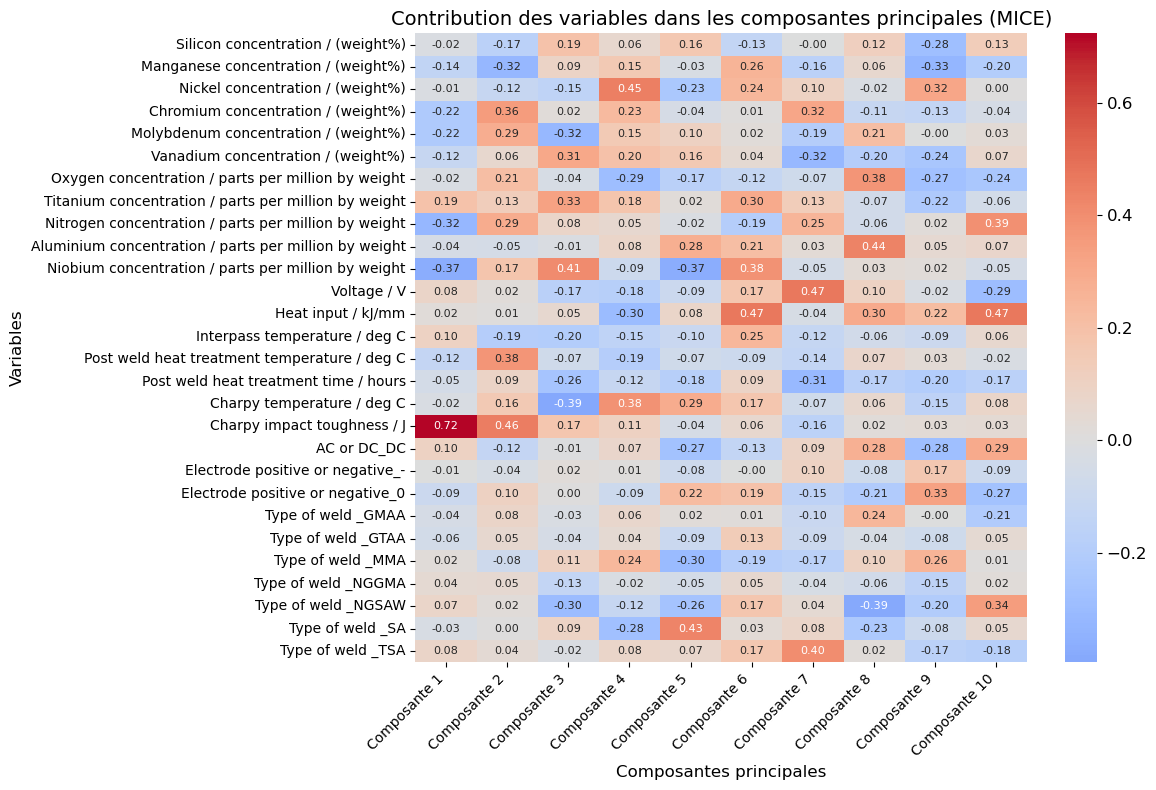

--- Traitement de Median ---
Longueur du DataFrame après PLS pour Median : (1652, 11)


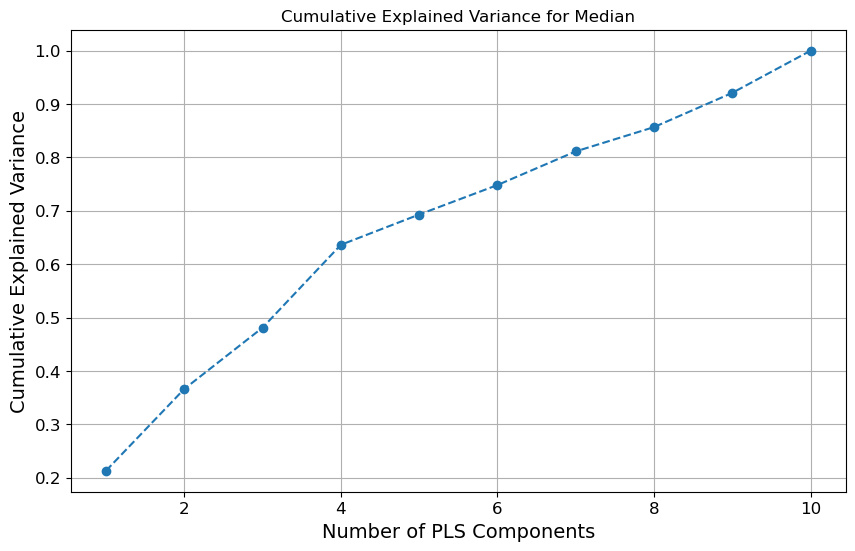

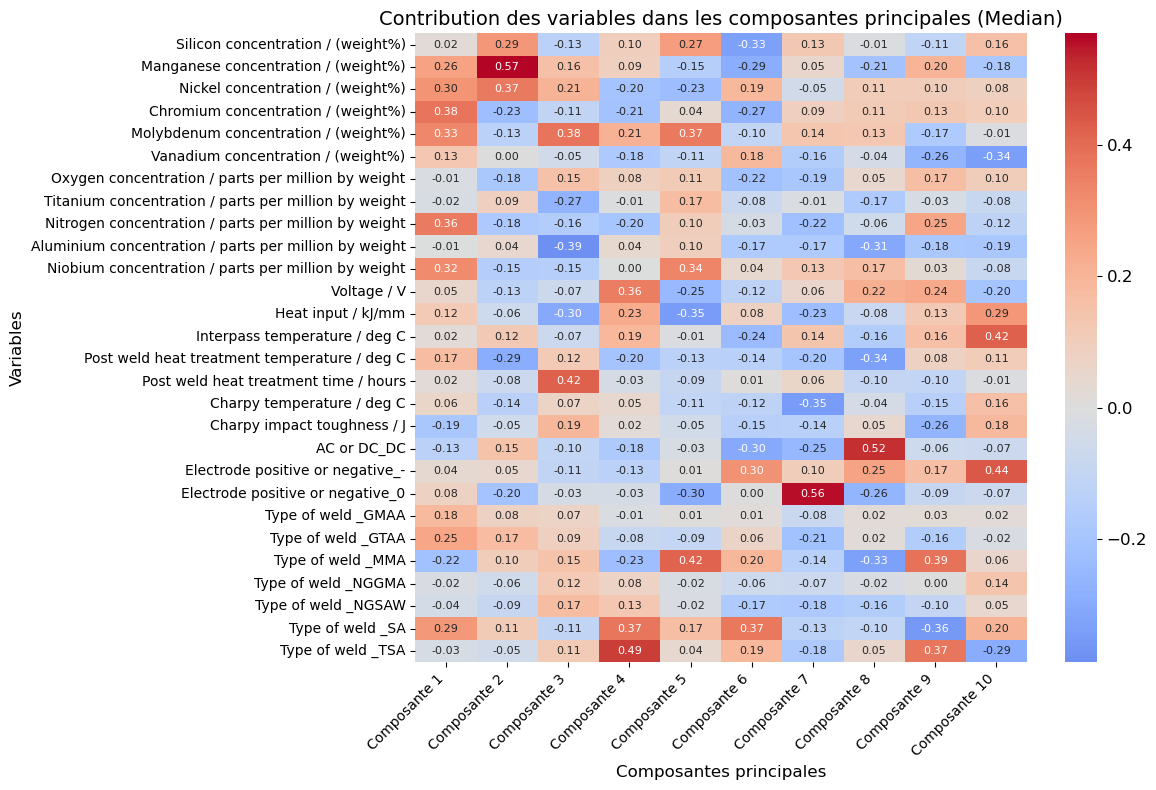

--- Traitement de Mean ---
Longueur du DataFrame après PLS pour Mean : (1652, 11)


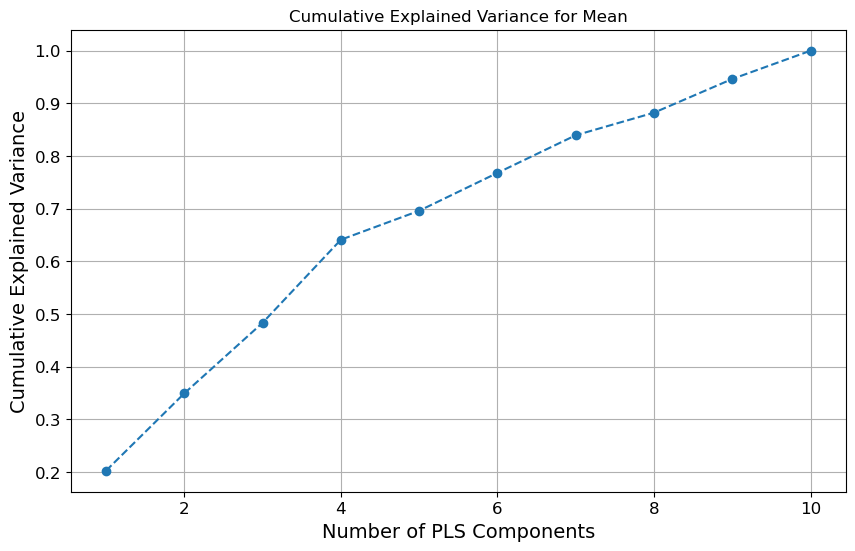

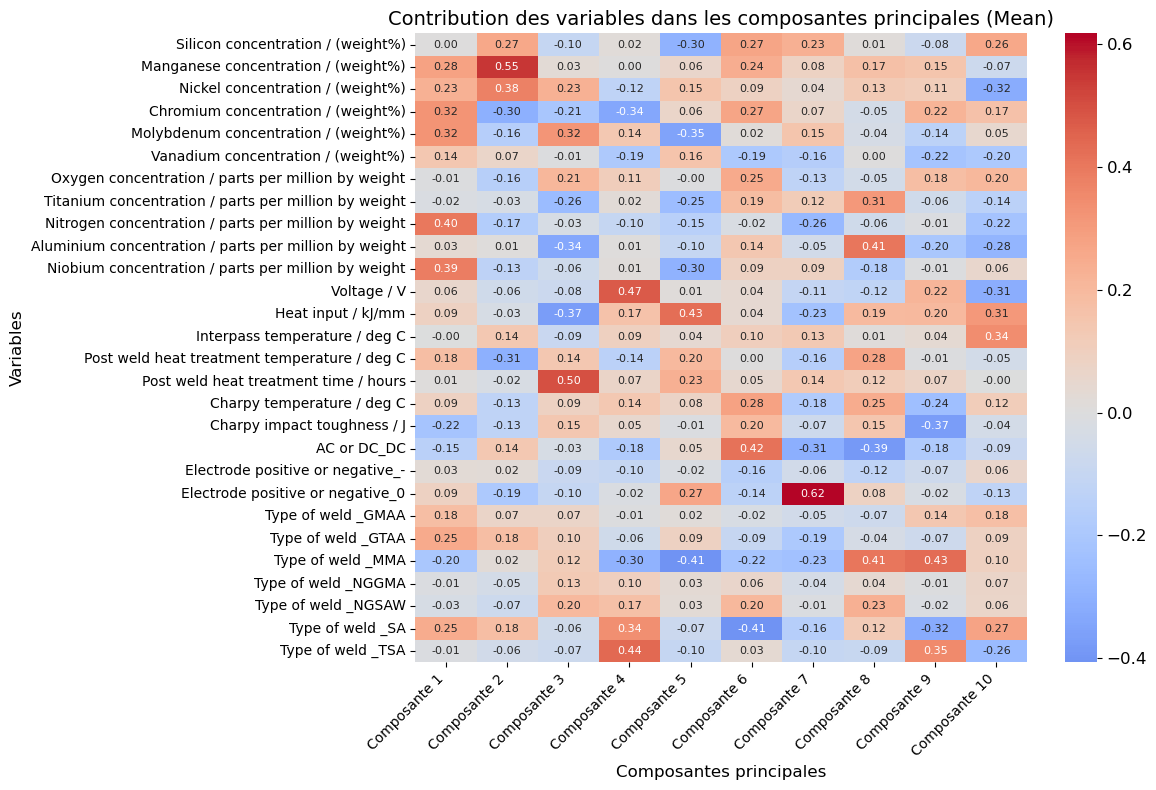

--- Traitement de Specific ---
Longueur du DataFrame après PLS pour Specific : (1652, 11)


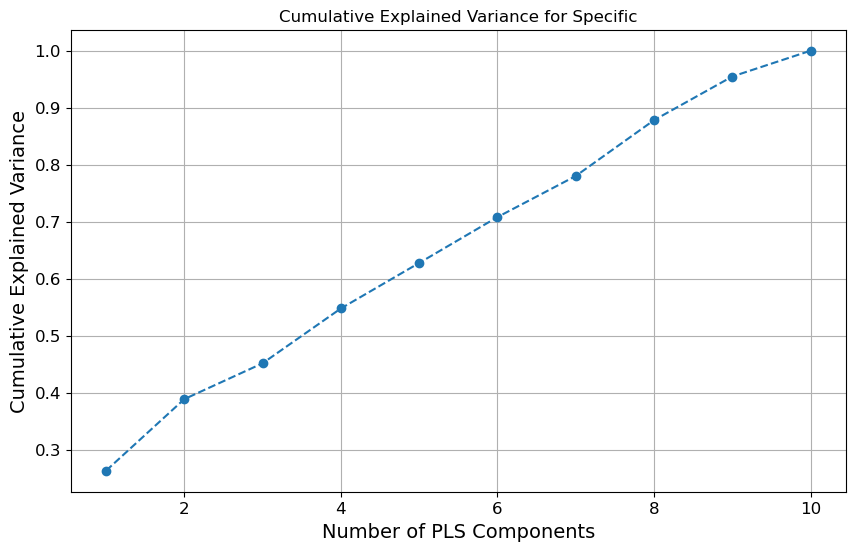

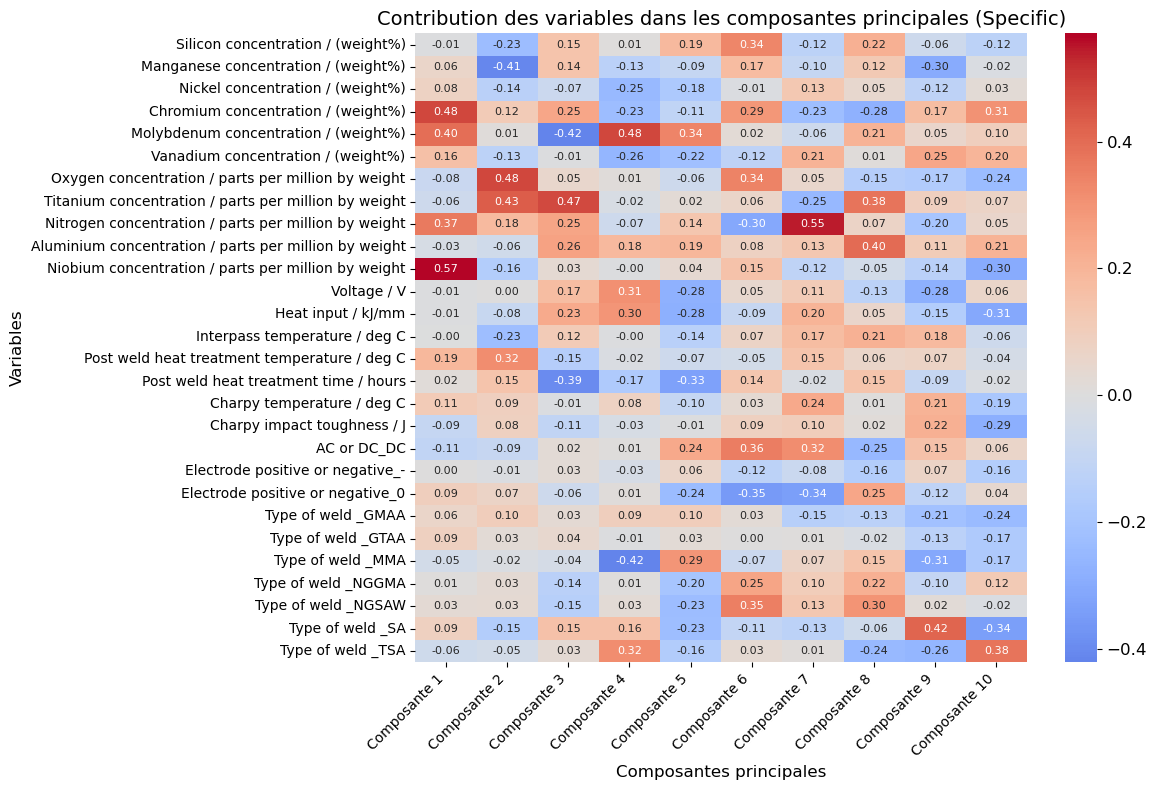

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cross_decomposition import PLSRegression
from sklearn.preprocessing import StandardScaler

def apply_pls_and_plot(df_without_target, df_target, dataset_name):
    # Vérifier que les variables catégorielles sont encodées
    print(f'--- Traitement de {dataset_name} ---')
    
    # Séparer les caractéristiques (X) et la cible (y)
    X = df_without_target #df_without_target_encoded 
    y = df_target

    # Normaliser les données
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Appliquer PLS
    pls = PLSRegression(n_components=10) 
    X_pls, y_pls = pls.fit_transform(X_scaled, y)

    # Créer un DataFrame pour les composantes PLS
    df_pls = pd.DataFrame(X_pls, columns=[f'PLS{i+1}' for i in range(X_pls.shape[1])])
    df_pls['Yield strength / MPa'] = y.reset_index(drop=True)

    # Afficher le résultat PLS
    print(f'Longueur du DataFrame après PLS pour {dataset_name} : {df_pls.shape}')
    return df_pls, pls

def plot_cumulative_variance(pls, dataset_name):
    explained_variance = np.var(pls.x_scores_, axis=0)
    explained_variance_ratio = explained_variance / np.sum(explained_variance)
    cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, marker='o', linestyle='--')
    plt.title(f'Cumulative Explained Variance for {dataset_name}')
    plt.xlabel('Number of PLS Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.grid(True)
    plt.show()

datasets = {
    "KNN": (df_without_target_mode_knn, df_target_mode_knn),
    "Regression": (df_without_target_mode_regression, df_target_mode_regression),
    "MICE": (df_without_target_mode_mice, df_target_mode_mice),
    "Median": (df_without_target_mode_median, df_target_mode_median),
    "Mean": (df_without_target_mode_mean, df_target_mode_mean),
    "Specific": (df_without_target_mode_specific, df_target_mode_specific)
    }

def plot_variable_contributions(pls, df_without_target_encoded, dataset_name):
    # Calculer les contributions des variables dans les composantes
    contributions = pls.x_weights_
    
    # Créer un DataFrame pour les contributions avec les noms des variables et des composantes
    df_contributions = pd.DataFrame(contributions, 
                                    index=df_without_target_encoded.columns, 
                                    columns=[f'Composante {i+1}' for i in range(contributions.shape[1])])

    # Visualiser la heatmap des contributions

    plt.figure(figsize=(12, 8))  # Ajuster la taille pour plus de lisibilité
    sns.heatmap(df_contributions, annot=True, cmap='coolwarm', center=0, annot_kws={"size": 8}, fmt=".2f")
    
    # Ajuster les labels pour la lisibilité
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(fontsize=10)
    
    # Ajouter un titre et des labels
    plt.title(f'Contribution des variables dans les composantes principales ({dataset_name})', fontsize=14)
    plt.xlabel('Composantes principales', fontsize=12)
    plt.ylabel('Variables', fontsize=12)
    
    # Afficher le graphique
    plt.tight_layout()
    plt.show()

pls_results = {}
for name, (df_without, df_target) in datasets.items():
    df_pls, pls_model = apply_pls_and_plot(df_without, df_target, name)
    pls_results[name] = df_pls
    plot_cumulative_variance(pls_model, name)
    # Tracer les contributions des variables aux composantes sans réencoder
    plot_variable_contributions(pls_model, df_without, name)


Nous faisons le choix de ne conserver que 8 composantes principales. En effet, la variance atteint un score satisfaisant (>0.8) pour toutes les méthodes d'imputation pour 8 composantes

# 4. ALGO PREDICTION
Plusieurs algorithmes sont testés pour réaliser la prédiction : 
- Random forest
- KNN
- Reg lin multiple
- semi supervisé


In [27]:
import pandas as pd
import numpy as np
# %pip install xgboost
from xgboost import XGBRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import KFold
import sklearn.metrics as metrics

# Initialiser les modèles
models = {
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Linear Regression': LinearRegression(),
    'K-Nearest Neighbors': KNeighborsRegressor(n_neighbors=5),
    'XGBoost': XGBRegressor(n_estimators=100, random_state=42),
    'AdaBoost': AdaBoostRegressor(n_estimators=100, random_state=42)
}

# Initialiser les datasets avec différentes méthodes d'imputation
datasets_without_target = {
    "KNN": pls_results["KNN"],
    "Regression": pls_results["Regression"],
    "MICE": pls_results["MICE"],
    "Median": pls_results["Median"],
    "Mean": pls_results["Mean"],
    "Specific": pls_results["Specific"]
}

# K-Fold Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Créer des DataFrames pour stocker les résultats des métriques
results_mse = pd.DataFrame(index=models.keys(), columns=datasets_without_target.keys())
results_rmse = pd.DataFrame(index=models.keys(), columns=datasets_without_target.keys())
results_mae = pd.DataFrame(index=models.keys(), columns=datasets_without_target.keys())
results_r2 = pd.DataFrame(index=models.keys(), columns=datasets_without_target.keys())
results_r2_adj = pd.DataFrame(index=models.keys(), columns=datasets_without_target.keys())

# Fonction pour encoder les variables catégorielles
def encode_categorical(df):
    return pd.get_dummies(df, drop_first=True)

# Boucle à travers les méthodes d'imputation
for imputation_name, df_pls in datasets_without_target.items():
    print(f"--- Méthode d'imputation : {imputation_name} ---")
    
    # Séparer les caractéristiques (X) et la cible (y)
    X = df_pls.drop(columns=['Yield strength / MPa'])  # Assurez-vous d'adapter le nom de la cible si nécessaire
    y = df_pls['Yield strength / MPa']  # Vérifiez que cela correspond à votre variable cible

    # Encoder les variables catégorielles du dataset X
    X_encoded = encode_categorical(X)
    
    # Boucle à travers les modèles
    for model_name, model in models.items():
        mse_scores = []
        mae_scores = []
        r2_scores = []
        
        # Validation croisée
        for train_index, test_index in kf.split(X_encoded):
            X_train, X_test = X_encoded.iloc[train_index], X_encoded.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]

            # Entraîner le modèle
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

            # Calculer les métriques
            mse = metrics.mean_squared_error(y_test, y_pred)
            mae = metrics.mean_absolute_error(y_test, y_pred)
            r2 = metrics.r2_score(y_test, y_pred)
            rmse = np.sqrt(mse)

            # Stocker les résultats
            mse_scores.append(mse)
            mae_scores.append(mae)
            r2_scores.append(r2)

        # Calculer la MSE moyenne et la stocker dans les tableaux
        results_mse.loc[model_name, imputation_name] = np.mean(mse_scores)
        results_rmse.loc[model_name, imputation_name] = np.mean(rmse)
        results_mae.loc[model_name, imputation_name] = np.mean(mae_scores)
        results_r2.loc[model_name, imputation_name] = np.mean(r2_scores)

        # Calculer le R² ajusté
        n = len(y)  # Nombre d'observations
        p = X_encoded.shape[1]  # Nombre de prédicteurs
        r2_adj = 1 - (1 - np.mean(r2_scores)) * (n - 1) / (n - p - 1)
        results_r2_adj.loc[model_name, imputation_name] = r2_adj

# Afficher les tableaux des résultats des métriques
print("\nMSE:\n", results_mse)
print("\nRMSE:\n", results_rmse)
print("\nMAE:\n", results_mae)
print("\nR²:\n", results_r2)
print("\nR² Ajusté:\n", results_r2_adj)


--- Méthode d'imputation : KNN ---
--- Méthode d'imputation : Regression ---
--- Méthode d'imputation : MICE ---
--- Méthode d'imputation : Median ---
--- Méthode d'imputation : Mean ---
--- Méthode d'imputation : Specific ---

MSE:
                              KNN   Regression         MICE       Median  \
Random Forest        2171.332889   661.134092   929.813985  1998.353089   
Linear Regression    4495.089284   135.256835   527.967187  3295.304679   
K-Nearest Neighbors  2249.946686   853.539079  1227.458125  2097.303252   
XGBoost               2198.69465   548.665447   773.751195  2098.929249   
AdaBoost             4228.839727  1855.803484  2213.170796  3575.995228   

                            Mean     Specific  
Random Forest        1990.650782   737.888667  
Linear Regression    3340.496345   822.183994  
K-Nearest Neighbors  2097.299658    828.64675  
XGBoost              2035.024256    819.26681  
AdaBoost              3248.07814  1961.949723  

RMSE:
                    

#### Semi-supervisé

In [28]:
# recupérer les df semi supervise
df_target_mode_semi_supervise = df_specific_semi_supervise['Yield strength / MPa']
df_without_target_mode_semi_supervise = df_specific_semi_supervise.drop(columns=['Yield strength / MPa'])

# Ignorer les avertissements
import warnings
warnings.filterwarnings("ignore")

# Récupérer les données étiquetées et non étiquetées
X_labeled = df_specific_semi_supervise.dropna(subset=["Yield strength / MPa"])
X_unlabeled = df_specific_semi_supervise[df_specific_semi_supervise["Yield strength / MPa"].isna()]

# Séparer les étiquettes (target) et les caractéristiques
y_labeled = X_labeled["Yield strength / MPa"]
X_labeled = X_labeled.drop(columns=["Yield strength / MPa"])
X_unlabeled = X_unlabeled.drop(columns=["Yield strength / MPa"])

# Création du classifieur de base
base_classifier = LogisticRegression(max_iter=1000)

# Création du classifieur semi-supervisé
self_training_model = SelfTrainingClassifier(
    base_classifier, 
    threshold=0.7,
    criterion='threshold', 
    max_iter=100,
    verbose=True
)

# Combiner les données étiquetées et non étiquetées
X_combined = pd.concat([X_labeled, X_unlabeled])
y_combined = pd.concat([y_labeled, pd.Series(-1, index=X_unlabeled.index)])  

# Entraîner le modèle
self_training_model.fit(X_combined, y_combined)

# Évaluation du modèle
accuracy_scores = cross_val_score(self_training_model, X_labeled, y_labeled, cv=5, scoring='accuracy')
auc_scores = cross_val_score(self_training_model, X_labeled, y_labeled, cv=5, scoring='roc_auc')

print(f"Précision moyenne : {accuracy_scores.mean():.2f}")
print(f"AUC moyenne : {auc_scores.mean():.2f}")

End of iteration 1, added 622 new labels.
End of iteration 2, added 107 new labels.
End of iteration 3, added 19 new labels.
End of iteration 4, added 9 new labels.
End of iteration 5, added 6 new labels.
End of iteration 6, added 4 new labels.
End of iteration 7, added 5 new labels.
End of iteration 8, added 1 new labels.
End of iteration 9, added 2 new labels.
End of iteration 10, added 4 new labels.
Précision moyenne : 0.80
AUC moyenne : 0.87


In [29]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

df_specific_semi_supervise2 = df_specific_knn_imputed.copy()  # Continue avec la copie précédente
regression_columns = [
    'Chromium concentration / (weight%)',
    'Molybdenum concentration / (weight%)', 
    'Oxygen concentration / parts per million by weight', 
    'Titanium concentration / parts per million by weight', 
    'Niobium concentration / parts per million by weight']
regression_imputer = IterativeImputer(estimator=LinearRegression(), random_state=0)
df_specific_semi_supervise2[regression_columns] = regression_imputer.fit_transform(df_specific_regression_imputed[regression_columns])


# Supposons que df_specific_semi_supervise2 est votre DataFrame
# Suppression des lignes avec des valeurs manquantes dans 'Yield strength / MPa'
df_clean = df_specific_semi_supervise2.dropna(subset=['Yield strength / MPa'])

# Séparer les données étiquetées et non étiquetées
X_labeled = df_clean.drop(columns=["Yield strength / MPa"])
y_labeled = df_clean["Yield strength / MPa"]

# Séparer les données non étiquetées
X_unlabeled = df_specific_semi_supervise2[df_specific_semi_supervise2["Yield strength / MPa"].isna()].drop(columns=["Yield strength / MPa"])

# Self-training loop pour la régression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor


def self_training_regression(X_labeled, y_labeled, X_unlabeled, model, threshold_factor=0.5, max_iter=10):
    for iteration in range(max_iter):
        print(f"Iteration {iteration + 1}")
        
        # Entraîner le modèle sur les données étiquetées
        model.fit(X_labeled, y_labeled)
        
        # Prédire sur les données non étiquetées
        y_pred = model.predict(X_unlabeled)
        
        # Calculer un seuil dynamique basé sur les prédictions
        threshold = threshold_factor * np.std(y_labeled)
        confident_indices = np.abs(y_pred - np.mean(y_labeled)) < threshold
        num_confident = np.sum(confident_indices)
        print(f"Nombre de prédictions confiantes : {num_confident}")
        
        # Si aucune prédiction n'est "fiable", arrêter l'itération
        if num_confident == 0:
            print("Aucune prédiction confidentielle. Arrêt.")
            break
        
        # Ajouter les données confidentielles au jeu de données étiquetées
        X_new = X_unlabeled[confident_indices]
        y_new = y_pred[confident_indices]
        
        if len(X_new) > 0:
            print(f"Données ajoutées : {len(X_new)}")
            X_labeled = np.vstack([X_labeled, X_new])
            y_labeled = np.concatenate([y_labeled, y_new])
        else:
            print("Aucune nouvelle donnée ajoutée.")
            continue
        
        # Mettre à jour les données non étiquetées
        X_unlabeled = X_unlabeled[~confident_indices]

        # Si toutes les données non étiquetées ont été utilisées, arrêter
        if len(X_unlabeled) == 0:
            print("Toutes les données non étiquetées ont été utilisées.")
            break
        
        # Évaluer le modèle sur les données étiquetées
        y_train_pred = model.predict(X_labeled)
        
        # Calculer les métriques MAE, MSE et R²
        mae = mean_absolute_error(y_labeled, y_train_pred)
        mse = mean_squared_error(y_labeled, y_train_pred)
        train_r2 = r2_score(y_labeled, y_train_pred)
        
        # Afficher les métriques après chaque itération
        print(f"MAE après l'itération {iteration + 1} : {mae}")
        print(f"MSE après l'itération {iteration + 1} : {mse}")
        print(f"R² après l'itération {iteration + 1} : {train_r2}")
        
        # Augmenter le seuil pour les itérations suivantes
        threshold_factor += 0.05

    return model


# Fixer l'alpha pour le modèle Ridge à 0.00001
ridge_model = Ridge(alpha=0.00001)

# Appliquer self-training pour la régression
trained_model = self_training_regression(X_labeled.values, y_labeled.values, X_unlabeled.values, ridge_model, max_iter=8)

# Évaluer le modèle sur un jeu de test
X_train, X_test, y_train, y_test = train_test_split(X_labeled, 
                                                    y_labeled, 
                                                    test_size=0.3, random_state=42)

# Retirer les lignes où y_test est NaN
valid_indices = ~y_test.isna()
X_test_valid = X_test[valid_indices]
y_test_valid = y_test[valid_indices]

# Entraîner le modèle Ridge avec alpha=0.00001 sur les données d'entraînement
trained_model.fit(X_train, y_train)

# Prédire avec le modèle entraîné
y_pred_test = trained_model.predict(X_test_valid)

# Calculer les métriques
mae = mean_absolute_error(y_test_valid, y_pred_test)
r2 = r2_score(y_test_valid, y_pred_test)

# Afficher les résultats
print(f"Alpha (fixé) : 0.00001")
print(f"MAE : {mae}")
print(f"R² : {r2}")

# Validation croisée pour le modèle Ridge avec alpha=0.00001
scoring = 'r2'
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # Ajout du shuffle ici

cv_results = cross_val_score(trained_model, X_labeled, y_labeled, cv=kf, scoring=scoring)

# Afficher les résultats de chaque fold
print("\nRésultats de la validation croisée pour R² :")
for i, score in enumerate(cv_results):
    print(f" Fold {i + 1}: R² = {score}")

# Afficher la moyenne
print(f"Moyenne du Coefficient de Détermination (R²) : {cv_results.mean()}")

Iteration 1
Nombre de prédictions confiantes : 379
Données ajoutées : 379
MAE après l'itération 1 : 14.996108724794626
MSE après l'itération 1 : 901.561553668354
R² après l'itération 1 : 0.8497259416850682
Iteration 2
Nombre de prédictions confiantes : 0
Aucune prédiction confidentielle. Arrêt.
Alpha (fixé) : 0.00001
MAE : 22.62446382408171
R² : 0.852114435375907

Résultats de la validation croisée pour R² :
 Fold 1: R² = 0.8446777618609507
 Fold 2: R² = 0.8234602092389883
 Fold 3: R² = 0.8311514542773345
 Fold 4: R² = 0.7272918296953195
 Fold 5: R² = 0.8469594304352744
Moyenne du Coefficient de Détermination (R²) : 0.8147081371015734
